# Libraries & Global Variables

In [1]:
%%capture
#@title Libraries
# !pip install rake-nltk multi-rake transformers scipy==1.9.0 networkx==3.0
!pip install mlxtend --upgrade --no-deps
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from rake_nltk import Rake
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import multi_rake
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import string
from collections import Counter
from transformers import LongformerTokenizer, LongformerModel, LongformerConfig, AutoTokenizer, LongformerForMaskedLM
import torch
import pickle
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.preprocessing import TransactionEncoder
from scipy.spatial import distance
import networkx as nx
import networkx.algorithms.community as nxcom
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt')
np.seterr(divide='ignore')
# Global variables to save the features/graphs of the embeddings
all_KNNs, all_graphs = {}, {}
from extractor import Extractor
import csv

# Methods

### Removing outliers

In [2]:
##@title Method for removing outliers
def remove_outliers(df:pd.DataFrame, col:str)->pd.DataFrame:
  '''
  Remove the outliers of the df[col] using interquartile
  '''
  df_no_outlier = df[[col]].copy()
  Q1 = df_no_outlier[col].quantile(0.25)
  Q3 = df_no_outlier[col].quantile(0.75)
  IQR = Q3 - Q1
  indx = df_no_outlier.loc[(df_no_outlier[col]<(Q1-1.5*IQR))|(df_no_outlier[col]>(Q3+1.5*IQR))].index.tolist()
  df_no_outlier = df_no_outlier.loc[~df_no_outlier.index.isin(indx)]
  print(f'quartile 1: {Q1}')
  print(f'quartile 3: {Q3}')
  print(f'Interquartile range: {IQR}')
  print(f'Number of documents before removing the outliers based on the lenght of document: {len(df)}')
  print(f'Number of documents after removing the outliers based on the lenght of document: {len(df_no_outlier)}')
  print(f'New Mean: {df_no_outlier.mean().values[0]}')
  print(f'New Max: {df_no_outlier.max().values[0]}')
  print(f'New Min: {df_no_outlier.min().values[0]}')
  print()
  return df_no_outlier

### Information about the dataset

In [3]:
##@title Information about the dataset
def info(df_train_sample:pd.DataFrame):
  display(df_train_sample.head())
  print('-'*10)
  print(df_train_sample.info())
  print('-'*10)
  print(df_train_sample.describe())
  print('-'*10)
  print(df_train_sample.isna().sum())
  print('-'*10)
  # There is a row with content = None but it has title and target_ind as well
  # Target_ind are the indices of labels and maps them to Yf.txt which has the labels
  df_train_sample[df_train_sample['content'].isna()]

### Unique length distribution of documents

In [4]:
##@title Unique length distribution of documents
def length_dis(contents:list, unique:bool):
  '''
  Convert documents to arrays to get the distribution of the number of words and numbers
  '''
  Docs, Lenght_Docs, Lenght_Uniques_Docs= {}, [], []
  for i, line in enumerate(contents):
    Line = "".join(c for c in line if c.isalnum() or c.isspace())
    # String to array by removing whitespaces and saving the string in Docs dictionary
    arr = Line.split()
    Docs[f'Doc_{i+1}'] = arr
    if len(arr) != 0:
      Lenght_Docs.append(len(arr))
      Lenght_Uniques_Docs.append(len(list(dict.fromkeys(arr))))
  # Histogram of the lenghts of the documents
  arr = np.array(Lenght_Uniques_Docs)
  if not unique:
    arr = np.array(Lenght_Docs)
  print('-> Lenghts of Documents (number of (unique) words and numbers)')
  print(f'Mean: {np.mean(arr)}')
  print(f'Max: {np.max(arr)}')
  print(f'Min: {np.min(arr)}')
  col = 'Number of all the Words and Numbers in a Document'
  df = pd.DataFrame({col: arr})
  f, axes= plt.subplots(2, 1, figsize=(8, 10))
  sns.histplot(data=df, x=col, kde=True, color='green', ax=axes[0], log_scale=[True, False])
  sns.boxplot(data=df, x=col, color='blue', ax=axes[1])
  plt.show()
  # Remove outliers and draw Histogram
  df_no_outlier = remove_outliers(df, col)
  f, axes= plt.subplots(figsize=(8, 5))
  sns.histplot(data=df_no_outlier, x=col, kde=True, color='g', ax=axes, log_scale=[True, False])
  plt.show()

### write_to_csv

In [5]:
##@title create csv for extracted key-phrases 

def write_to_csv(file_path, data_list):
    # data_list should be a list of lists, where each inner list represents a row in the CSV

    header = ['phrase', 'frequency', 'rank']
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

        # Write the data to the CSV file row by row
        for row in data_list:
            writer.writerow(row)

### get common key-phrases

In [6]:
##@title get common key-phrases

## get common key-phrases
def get_intersected_values(obj):
    class_sets = {class_name: set(phrase) for class_name, phrase in obj.items()}

    # Find common phrases
    return set.intersection(*class_sets.values())

# for rKNN
def get_common_key_phrases_from_nodes(neighbors,properties,phrase_index=3):
    data = {}
    for index in neighbors:
        t= f"node_{index}"
        data[index]= properties[keys[index]][phrase_index]
     
    return get_intersected_values(data)

## for Community
def get_common_key_phrases_from_community(community,doc_keyphrase):
    phraseList={}
    for k, j in enumerate(community):
        temp = []
        for doc in range(len(j)):
            temp = temp + doc_keyphrase[doc]      
        temp = list(dict.fromkeys(temp))
        
        phraseList[k]=temp
    return get_intersected_values(phraseList)

### TF-IDF calculation

In [7]:
##@title TF-IDF calculation
def tf_idf_calculation(document:list, vocab:list)->pd.DataFrame:
  '''
  Calculate tf-idf of the words of vocab in document
  '''
  tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
  tfidf_vector = tfidf_vectorizer.fit_transform(document)
  feature_names = tfidf_vectorizer.get_feature_names_out()

  # Mean of word TF-IDF values
  word_tfidf = {}
  for i in range(len(feature_names)):
    word_tfidf[feature_names[i]] = np.mean(tfidf_vector[:, i].toarray())

  df_word_tfidf = pd.DataFrame({'tf_idf': word_tfidf.values()}, index=word_tfidf.keys())
  df_word_tfidf.sort_values(by=['tf_idf'], ascending=False, inplace=True)

  return df_word_tfidf

# Classs

### Key-phrase Filter

In [8]:
##@title Filtering steps
class Filter:
    '''
    Filtering the documents
    '''
    def __init__(self, tf_idf:pd.DataFrame):
      self.tf_idf = tf_idf

    def remove(self, top_phrases:list, contents:list)->list:
      '''
      Removing Documents not having the key-phrases
      '''
      # print(len(top_phrases))
      # print(len(contents))
      new_contents =[]
      for doc in contents:
        if any(phrase in doc for phrase in top_phrases):
          new_contents.append(doc)
      return new_contents

    def tf_idf_filter(self, contents:list, df_keyphrase:pd.DataFrame, threshold:float)->[list, pd.DataFrame]:
      '''
      Filtering based on the existence of the words with high tf-idf weights inside the key-phrases
      '''
      # Key-phrases having at least one word with high tf-idf value
      extracted_key_phrase =[]
      for ind in df_keyphrase.index:
        phrases = df_keyphrase.loc[ind,'phrases']
        for phrase in set(phrases.split()):
          try:
            if (phrase in self.tf_idf.index) and (self.tf_idf['tf_idf'][str(phrase)] >= threshold):
              new_data={'phrases': phrases, 'frequency':df_keyphrase.loc[ind,'frequency'],'rank':df_keyphrase.loc[ind,'rank']}
              extracted_key_phrase.append(new_data)
              # extracted_key_phrase.append({'phrases': phrases, 'frequency':df_keyphrase.loc[ind,'frequency'],'rank':df_keyphrase.loc[ind,'rank']})
              break
          except:
            print(f'Error: phrase: {phrase} doc : {phrases}')

      print(f'Remaining key-phrases with words with tf-idf weights >= {threshold} --> {len(extracted_key_phrase)}')
      new_df_keyphrase = pd.DataFrame(extracted_key_phrase)
      return self.remove(new_df_keyphrase['phrases'], contents), new_df_keyphrase

    def keyPhrase_freq_filter2(self, contents:list, df_keyphrase:pd.DataFrame, top_percent:int)->[list, pd.DataFrame]:
        '''
        Filtering based on the frequent key-phrases 
        '''
        de_freq = df_keyphrase['phrases'].value_counts()
        # remove phrases only have special characters
        phrases = [i for i in de_freq.index if len(re.sub('[^A-Za-z0-9]+', '', i))>0]
        top_phrases = phrases[:len(phrases)*top_percent//100]
        print(f'Remaining key-phrases with top {top_percent} percent of frequent key-phrases --> {len(top_phrases)}')
        
        extracted_key_phrase =[]
        for phrase in top_phrases:
            for ind in df_keyphrase.index:
                if phrase == df_keyphrase.loc[ind,'phrases']:
                    new_data={'phrases': df_keyphrase.loc[ind,'phrases'], 'frequency':df_keyphrase.loc[ind,'frequency'],'rank':df_keyphrase.loc[ind,'rank']}
                    extracted_key_phrase.append(new_data)
                    break
        
        new_df_keyphrase = pd.DataFrame(extracted_key_phrase)
        return self.remove(new_df_keyphrase['phrases'], contents), new_df_keyphrase

    def keyPhrase_freq_filter(self, contents:list, df_keyphrase:pd.DataFrame, top_percent:int)->[list, pd.DataFrame]:
      '''
      Filtering based on the frequent key-phrases
      '''
      sort_frequency_wise = df_keyphrase.sort_values(by='frequency', ascending=False)
      new_df_keyphrase = sort_frequency_wise[:len(sort_frequency_wise)*top_percent//100]
      print(f'Remaining key-phrases with top {top_percent} percent of frequent key-phrases --> {len(new_df_keyphrase)}')
      return self.remove(new_df_keyphrase['phrases'], contents), new_df_keyphrase

    def word_freq_filter(self, contents:list, df_keyphrase:pd.DataFrame, top_percent:int)->[list, pd.DataFrame]:
        '''
        Filtering based on the existence of the frequent word inside the key-phrases
        '''
        # sorted frequent_word_list
        sorted_frequent_word_list = Counter(word.lower() for phrase in df_keyphrase['phrases'] for word in phrase.split()).most_common()

        # Get top frequent word
        top_frequent_word_list = set(word for word, count in sorted_frequent_word_list[:int(len(sorted_frequent_word_list) * top_percent / 100)])

        # get new key-phrase [at least one phrase in top_frequent_word_list]
        new_key_phrases = [phrase for phrase in df_keyphrase['phrases'] if any(word in top_frequent_word_list for word in phrase.lower().split())]

        print(f'Remaining key-phrases with top {top_percent} percent of frequent words --> {len(new_key_phrases)}')
        
        extracted_key_phrase =[]
        for phrase in new_key_phrases:
            for ind in df_keyphrase.index:
                if phrase == df_keyphrase.loc[ind,'phrases']:
                    new_data={'phrases': df_keyphrase.loc[ind,'phrases'], 'frequency':df_keyphrase.loc[ind,'frequency'],'rank':df_keyphrase.loc[ind,'rank']}
                    extracted_key_phrase.append(new_data)
                    break
              
        
        new_df_keyphrase = pd.DataFrame(extracted_key_phrase)
        # display(new_df_keyphrase)
        # print(len(contents))
        return self.remove(new_df_keyphrase['phrases'], contents), new_df_keyphrase

### RKNN

In [9]:
##@title Class for creating (Recursive) KNNs and derive features to compare them

from pandas.core.arrays import boolean
class KNN:
    def __init__(self):
        pass

    def bin_vec_add(self, df_phrases:pd.DataFrame, ind_doc:list)->int:
        # ----------------------------
        # Count the occurences of 2 when adding binary vectors
        # ----------------------------
        occ_2 = 0
        for i in range(len(ind_doc)):
            for j in range(i+1, len(ind_doc), 1):
                a = df_phrases.astype(int).loc[df_phrases.index[ind_doc[i]], :].values
                b = df_phrases.astype(int).loc[df_phrases.index[ind_doc[j]], :].values
                occ_2 += np.count_nonzero((a+b) == 2)
        return occ_2

    def recursive_knn(self, sim:np.array, Doc_keyphrase:dict, Docs_with_top_phrases:list, Dict:dict, Properties:dict, node:int, current:int, neighbors:list, k:int, nHops:int, counter:int)->[dict, dict]:
        # ----------------------------
        # Create Recursive KNN based on k and nHops
        # Repeat the same approach as knn, but for the neighbors
        # Dict: store RKKN | Properties: store the properties (# Neighbors, Mean Cos-Sim, # Cats) of RKNN | node: the main node of KNN |
        # current: current node of RKNN we are checking | counter: which nHops (layer) we are at
        # ----------------------------
        if counter <= nHops:
            # Update the whole neighbors of the node
            Properties[node][1] = list(set(Properties[node][1]).union(set(neighbors)))
            # Find closest neighbors
            for i in neighbors:
                if i != current:
                    ind = sim[i].argsort()[-k-1:]
                    li = []
                    try:
                        # Save the categories
                        for j in ind:
                            li = li + Doc_keyphrase[Docs_with_top_phrases[j]]
                    except:
                        pass
                    ind_doc = [Docs_with_top_phrases[j] for j in ind]
                    # Create Recursive KNN (next layer)
                    try:
                        Dict[node][str(counter)].append({str(Docs_with_top_phrases[i]): [np.array(ind_doc), sim[i][ind], np.array(li)]})
                    except:
                        Dict[node][str(counter)] = [{str(Docs_with_top_phrases[i]): [np.array(ind_doc), sim[i][ind], np.array(li)]}]
                    # Update the properties of the node
                    Properties[node][2].append(sim[i][ind])
                    Properties[node][3] = list(set(Properties[node][3]).union(set(li)))
                    # KNN for neighbor i
                    Dict, Properties = self.recursive_knn(sim, Doc_keyphrase, Docs_with_top_phrases, Dict, Properties, node, current=i, neighbors=ind, k=k, nHops=nHops, counter=counter+1)
        return Dict, Properties

    def knn(self, sim:np.array, Doc_keyphrase:dict, df_phrases:pd.DataFrame, Docs_with_top_phrases:list, k:int, nHops:int)->[dict, dict, dict, pd.DataFrame]:
        # ----------------------------
        # KNN and Recursive KNN
        # Create the first nHops layer (KNN) with finding the closest neighbors using the similarity matrix
        # sim: Similarty Matrix | Doc_keyphrase: documents as the keys and their categories as the values | df_phrases: document-category matrix |
        # Docs_with_top_phrases: list of selected documentes | k: number of neighbors (KNN) | nHops: how many layers does RKNN have
        # ----------------------------
        Dict, Properties, Scores = {}, {}, {}
        df_graph = pd.DataFrame(sim.copy(), columns=Docs_with_top_phrases, index=Docs_with_top_phrases)


        # Create KNN
        # Find closest neighbors
        for i in range(len(sim)):
            ind = sim[i].argsort()[-k-1:]
            li = []
            try:
                # Save the categories
                for j in ind:
                    li = li + Doc_keyphrase[Docs_with_top_phrases[j]]
            except:
                pass
            node = Docs_with_top_phrases[i]
            ind_doc = [Docs_with_top_phrases[j] for j in ind]
            # Update adjacency matrix
            df_graph.loc[node, :] = 0
            df_graph.loc[node, ind_doc] = 1
            df_graph.loc[node, node] = 0

            # Scoring method for each node
            # 1. Hamming Distance
            # ...
            # 2. Union of Cats# Scores[node] = len(set(li))
            # 3. Adding charactristic vectors
            try:
                Scores[node] = self.bin_vec_add(df_phrases, ind_doc)
            except:
                pass
            # KNN (First layer)
            Dict[node] = {'1': {str(node): [np.array(ind_doc), sim[i][ind], np.array(li)]}}
            Properties[node] = [0, [], [sim[i][ind]], []]
            # Create Recursive KNN
            Dict, Properties = self.recursive_knn(sim, Doc_keyphrase, Docs_with_top_phrases, Dict, Properties, node=node, current=i, neighbors=ind, k=k, nHops=nHops, counter=2)
            # Update the properties of the node
            Properties[node][0] = len(Properties[node][1])
            Properties[node][1] = np.array([Docs_with_top_phrases[j] for j in Properties[node][1]])
            Properties[node][2] = np.array(Properties[node][2])

        return Dict, Properties, Scores, df_graph



    def Extract_Features(self, R_KNN_Properties:dict, cos_or_L2:str, name:str, community_level:bool):
        # ----------------------------
        # Extract features and plot the distribution of the extracted features
        # ----------------------------
        global all_KNNs
        # finding 5% of the docs with most and least neighbors in their recursive knn
        keys = np.array(list(dict(sorted(R_KNN_Properties.items(), key=lambda item: item[1][0])).keys()))
        # Extracted Properties from R_KNN_Properties: [# neighbors, mean cos-sim or L2, # cats]
        Extracted_Properties = []
        for i in keys:
            Extracted_Properties.append([R_KNN_Properties[i][0], R_KNN_Properties[i][2].mean(), len(R_KNN_Properties[i][3])])
        Extracted_Properties = np.array(Extracted_Properties)
        if community_level == True:
            return Extracted_Properties, keys
        else:
            all_KNNs[name]['all'] = []
            all_KNNs[name]['all'].append(Extracted_Properties)
            return keys



    def Plot(self, axes, i, k, arr, counter, colors, label, Log_scale):
        # ----------------------------
        # Plot the histogrms
        # ----------------------------
        df_temp = pd.DataFrame({i: arr})
        sns.histplot(data=df_temp, x=i, ax=axes[counter][0], log_scale=Log_scale, color=colors[k], element='step', label=list(all_KNNs.keys())[k], kde=True)
        df_temp = pd.DataFrame({i: arr[:(len(keys)*5//100)]})
        sns.histplot(data=df_temp, x=i, ax=axes[counter+1][0], log_scale=Log_scale, color=colors[k],  element='step', label=list(all_KNNs.keys())[k], kde=True)
        df_temp = pd.DataFrame({i: arr[-(len(keys)*5//100):]})
        sns.histplot(data=df_temp, x=i, ax=axes[counter+2][0], log_scale=Log_scale, color=colors[k], element='step', label=list(all_KNNs.keys())[k], kde=True)
        if list(all_KNNs.keys())[k] != 'random':
            # Excluding random
            df_temp = pd.DataFrame({i: arr})
            sns.histplot(data=df_temp, x=i, ax=axes[counter][1], log_scale=Log_scale, label=list(all_KNNs.keys())[k], color=colors[k], element='step')
            df_temp = pd.DataFrame({i: arr[:(len(keys)*5//100)]})
            sns.histplot(data=df_temp, x=i, ax=axes[counter+1][1], log_scale=Log_scale, label=list(all_KNNs.keys())[k], color=colors[k], element='step')
            df_temp = pd.DataFrame({i: arr[-(len(keys)*5//100):]})
            sns.histplot(data=df_temp, x=i, ax=axes[counter+2][1], log_scale=Log_scale, label=list(all_KNNs.keys())[k], color=colors[k], element='step')
        for k, kk in enumerate(['all docs', '5% docs with least neighbors', '5% docs with most neighbors']):
            # Add title and labels
            axes[counter+k][0].legend()
            axes[counter+k][0].set_title(kk)
            axes[counter+k][1].legend()
            axes[counter+k][1].set_title(kk)
        return axes



    def Plot_Features(self):
        # ----------------------------
        # Plot features
        # ----------------------------
        global all_KNNs
        f, axes= plt.subplots(9, 2, figsize=(23, 50))
        counter = 0
        colors = ['red', 'blue', 'green', 'grey']
        sim = 'mean L2-norm'
        if 'cos' in cos_or_L2:
            sim = 'mean cos-sim'
        for count, i in enumerate(['# neighbors', sim, '# KeyPhrase']):
            for k in range(len(all_KNNs.keys())):
                try:
                    # Including random Matrix if available
                    arr = all_KNNs[list(all_KNNs.keys())[k]]['all'][0]
                    label = list(all_KNNs.keys())[k]
                    axes = self.Plot(axes, i, k, arr[:, count], counter, colors, label, Log_scale=[True, False])
                except:
                    pass
            counter += 3
        plt.show()



    def Plot_Scores(self, keys, KNN_scores):
        # ----------------------------
        # Calculate and plot the scores
        # ----------------------------
        global all_KNNs
        f, axes= plt.subplots(3, 2, figsize=(23, 17))
        counter = 0
        cl = '# 2s in binary vector addition for each node in RKNNs'
        colors = ['red', 'blue', 'green', 'grey']
        for k in range(len(all_KNNs.keys())):
            arr = all_KNNs[list(all_KNNs.keys())[k]]['scores']
            label=list(all_KNNs.keys())[k]
            axes = self.Plot(axes, cl, k, arr, counter, colors, label, Log_scale=[False, False])
        plt.show()

In [10]:
##@title KNN and Recursive KNN {form-width: "400px"}
def Create_RKNN(KNN_object:object, Docs_with_top_phrases:list, embedding_name:list,
                embedding_file:list, cos_or_L2:str, nHops:int, K: int,
                Doc_keyphrase: dict = None, df_phrases: pd.DataFrame = None):
    # Global variables to save the features/graphs of the embeddings
    global all_KNNs, all_graphs

    for vec_embedding in embedding_file:
        for name in embedding_name:
            if name in vec_embedding:
                all_KNNs[name] = {}
                Vecs = []
                # Read vector embeddings
                if vec_embedding != 'random':
                    try:
                        Vectors = open(vec_embedding, 'r')
                        Lines = Vectors.readlines()
                        for i, line in enumerate(Lines):
                            arr = line.split()
                            Vecs.append([float(j) for j in arr])
                        Vecs = np.array(Vecs)
                    except:
                        Vecs = pickle.load(open(vec_embedding, "rb"))
                    # Calculate similarity Matrix
                    similarity = pd.DataFrame()
                    if cos_or_L2 == 'cos': # Cos-Sim
                        # print(Docs_with_top_phrases)
                        cos_sim = cosine_similarity(Vecs[Docs_with_top_phrases])
                        similarity = cos_sim.copy()
                    # else: # L2 Norm
                    #     L2 = Object.L2_Norm(Vecs, Docs_with_top_phrases)
                    #     similarity = L2.values
                # else: # Create a Random matrix as similarity
                #     if cos_or_L2 == 'cos':
                #         similarity = np.random.rand(len(Docs_with_top_phrases), len(Docs_with_top_phrases))
                    # else:
                    #     # Random Matrix using L2 norm
                    #     similarity = np.random.normal(loc=1.8829, scale=0.4632, size=(len(Docs_with_top_phrases), len(Docs_with_top_phrases)))
                # Create Recursive KNN
                # if Use_Cats:
                    # print(df_phrases[used_cats])
                    # Dict_top_k, R_KNN_Properties, KNN_scores, df_knn_graph = Object.knn(similarity, Doc_keyphrase, df_phrases[used_cats], Docs_with_top_phrases, int(K), int(nHops))
                    Dict_top_k, R_KNN_Properties, KNN_scores, df_knn_graph = Object.knn(similarity, Doc_keyphrase, df_phrases, Docs_with_top_phrases, int(K), int(nHops))
                # else:
                    # Dict_top_k, R_KNN_Properties, KNN_scores, df_knn_graph = Object.knn(similarity, [], [], Docs_with_top_phrases, int(K), int(nHops))
                # Create and save data needed for creating Networkx graph and detect communities to all_graphs
                df_similarty = pd.DataFrame(similarity, index=df_knn_graph.index, columns=df_knn_graph.columns)
                all_graphs[name] = {'df_graph': df_knn_graph, 'df_similarty': df_similarty, 'Graph': None, 'Communities': []}
                # Extract features of the Recursive KNNs and save it to all_KNNs
                keys = Object.Extract_Features(R_KNN_Properties, cos_or_L2, name,community_level=False)
                all_KNNs[name]['scores'] = []
                for i in keys:
                    all_KNNs[name]['scores'].append(KNN_scores[i])
    return Dict_top_k, R_KNN_Properties, KNN_scores, keys

## Community

In [11]:
##@title Class for creating a networkx graph and detect the communities
class Community:
    def __init__(self):
        pass

    def set_node_community(self, G:nx.Graph, communities:list)->nx.Graph:
        # ----------------------------
        # Define community nodes
        # ----------------------------
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1
        return G


    def set_edge_community(self, G:nx.Graph)->nx.Graph:
        # ----------------------------
        # Define community edges
        # ----------------------------
        '''Find internal edges and add their community to their attributes'''
        for v, w, in G.edges:
            if G.nodes[v]['community'] == G.nodes[w]['community']:
                # Internal edge, mark with community
                G.edges[v, w]['community'] = G.nodes[v]['community']
            else:
                # External edge, mark as 0
                G.edges[v, w]['community'] = 0
        return G


    def get_color(self, i, r_off=1, g_off=1, b_off=1):
        # ----------------------------
        # Define colors for nodes
        # ----------------------------
        '''Assign a color to a vertex.'''
        n = 20
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)
        return (r, g, b)


    def Community_Detection(self, df_graph:pd.DataFrame, df_similarty:pd.DataFrame, name:str, Resolution:float)->[nx.Graph, list]:
        # ----------------------------
        # Create a networkx graph from the adjacency matrix and find the communities
        # ----------------------------
        graph = nx.from_numpy_array(df_graph.values)
        graph = nx.relabel_nodes(graph, dict(enumerate(df_graph.columns)))
        # Give similarities as weights to edges
        for v, w, in graph.edges:
            graph.edges[v, w]['similarity'] = df_similarty.loc[v][w]
        # Detect Communities
        communities = sorted(nxcom.greedy_modularity_communities(graph, weight='similarity', resolution=Resolution), key=len, reverse=True)
        print(f"The KNN graph has \033[3;32m{len(communities)}\033[0;30m communities.")
        # Set node and edge communities
        graph = self.set_node_community(graph, communities)
        graph = self.set_edge_community(graph)
        try:
            # plot
            node_color = [self.get_color(graph.nodes[v]['community']) for v in graph.nodes]
            # Set community color for edges between members of the same community (internal) and intra-community edges (external)
            external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
            internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]
            internal_color = ['black' for e in internal]
            pos = nx.spring_layout(graph)
            fig = plt.figure(figsize=(10, 10))
            # Draw external edges
            nx.draw_networkx(graph, pos=pos, node_size=10, edgelist=external, edge_color="silver", with_labels=False, )
            # Draw nodes and internal edges
            nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, with_labels=False)
            plt.title(name)
            plt.show()
        except Exception as e:
            print(e)

        return graph, communities

# Main

### Load the sample testset

In [12]:
##@title Load the sample testset

# Specify the file path of the text file
path = 'data/bert'
file_path = f'{path}/Sample_test.txt' # 5000 review

# Read the text data from the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Create a DataFrame from the lines of text
df_test_sample = pd.DataFrame({'text': lines})

# Display the DataFrame
display(df_test_sample)

text
0     ﻿Protect the sleek beauty of a Ducane gas gril...
1     Enhance your garden with this whimsical copper...
2     This BIA Fiji Teapot will complement your othe...
3     "Ideally suited to students of biology, at eit...
4     "Matter and Memory was the diagnosis of a cris...
...                                                 ...
4995                                         CASSETTE\n
4996  Janice T. Connell is the bestselling author of...
4997             Available storage capacity may vary.\n
4998  Smoothie Joe has spent years developing the pe...
4999  "A wonderful collection of poetry that has sto...

[5000 rows x 1 columns]

### Document's Length distribution

-> Lenghts of Documents (number of (unique) words and numbers)
Mean: 113.38590872698158
Max: 2479
Min: 1


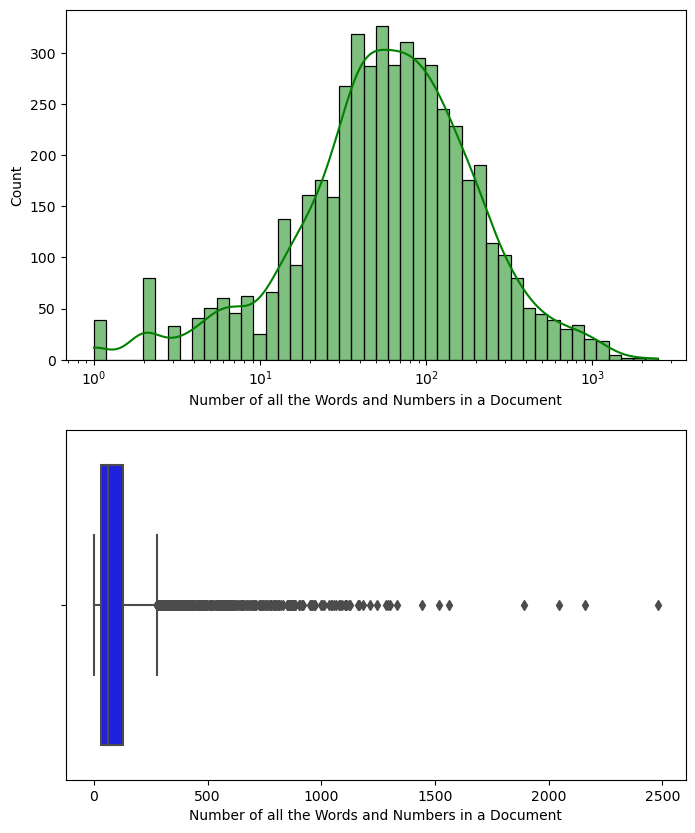

quartile 1: 30.0
quartile 3: 129.0
Interquartile range: 99.0
Number of documents before removing the outliers based on the lenght of document: 4996
Number of documents after removing the outliers based on the lenght of document: 4578
New Mean: 73.8602009611184
New Max: 277
New Min: 1



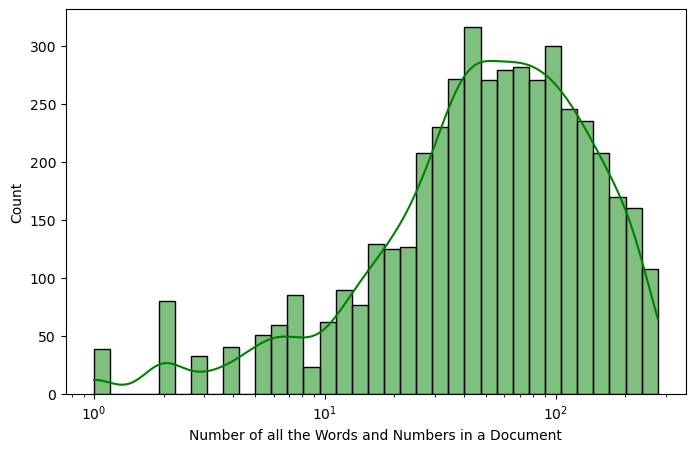

In [13]:
##@title Document's Length distribution
contents = df_test_sample['text'].dropna()
length_dis(contents, unique=True)

## Key-phrase Extraction

In [14]:
#@title textrank
df_test_sample['text'] = df_test_sample.text.fillna(' ')
df_test_sample['text'] = df_test_sample['text'].str.lower()

POS_KEPT = ["NOUN"]
reviewes = ' '.join(df_test_sample['text'])
extractor = Extractor()
doc = extractor.extract(reviewes,POS_KEPT)

data_list = []
for phrase, (rank, count) in doc:
    # print(phrase, count, rank)
    data_list.append([phrase, count, rank])
print(len(data_list))
write_to_csv(file_path=f"{path}/output/csv_key_phrases.csv",data_list=data_list)

50014


## Key-phrase Filter

### key-phrase word length filter

In [22]:
##@title key-phrase length
# Dataframe of key-phrases
df_keyphrase =pd.read_csv(f'{path}/output/csv_key_phrases.csv')
# Rename a single column
df_keyphrase.rename(columns={'phrase': 'phrases'}, inplace=True)
df_keyphrase.head()

# phrase word count
df_keyphrase['word_count'] = df_keyphrase['phrases'].str.split().apply(len)
sorted_freq_wise = df_keyphrase.sort_values(by='word_count', ascending=False) 
print('df_keyphrase size:', len(df_keyphrase))

# Filter out rows with word_count >= 5
df_keyphrase = df_keyphrase[df_keyphrase['word_count'] < 6]

print('After length(5) filtering df_keyphrase size:', len(df_keyphrase))

df_keyphrase = df_keyphrase.sort_values(by='word_count', ascending=False) 
df_keyphrase

df_keyphrase size: 50015
After length(5) filtering df_keyphrase size: 47492


phrases  frequency      rank  \
5811   cal.copyright 1994 reed business information          1  0.011080   
29709       this rugged mil.-style utility clothing          1  0.003185   
12711              carrolls old love alison chapley          1  0.007466   
3662             tv and video entertainment devices          1  0.013210   
22140       the myoplex precision nutrition formula          1  0.004781   
...                                             ...        ...       ...   
22518                                         buses         22  0.004689   
22516                                         wrist         26  0.004689   
22515                                        shares         25  0.004689   
37820                                     trellises          1  0.001824   
40520                                     lullabies          5  0.001515   

       word_count  
5811            5  
29709           5  
12711           5  
3662            5  
22140           5  
...           ...  
22518           1  
22516           1  
22515           1  
37820           1  
40520           1  

[47492 rows x 4 columns]

### Calculate tf-idf of the (key-phrases') words in documents

In [23]:
##@title tf-idf of the (key-phrases') words in documents {form-width:"400px"}
words_in_phrases = list(set([word for line in df_keyphrase['phrases'].values.tolist() for word in line.split()]))
df_word_tfidf = tf_idf_calculation(df_test_sample['text'], vocab=words_in_phrases)


In [24]:
len(df_word_tfidf[df_word_tfidf['tf_idf'] > 0.004])

138

tf_idf
the   0.113973
and   0.083623
of    0.072746
to    0.054092
in    0.046130
is    0.035978
this  0.028177
on    0.022143
that  0.021210
as    0.020906

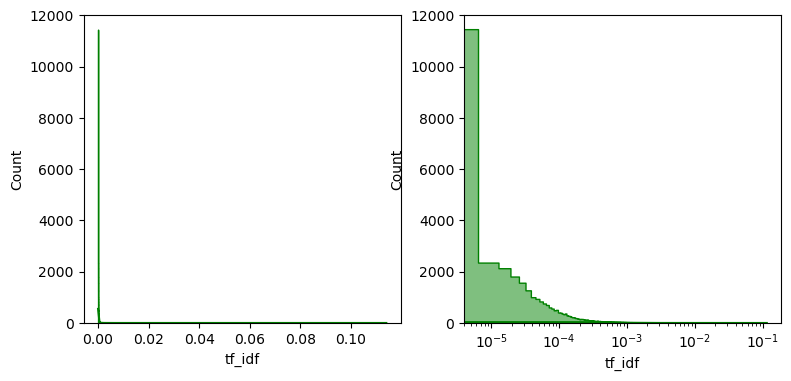

In [25]:
display(df_word_tfidf.head(10))
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(data=df_word_tfidf, x='tf_idf', element='step', kde=True, ax=axes[0], color='green')
sns.histplot(data=df_word_tfidf, x='tf_idf', element='step', kde=True, ax=axes[1], color='green')
axes[1].set_xscale('log')
plt.show()

### Filter Key-phrase and remove documents

In [26]:
#@title Remove Docs
filter = Filter(df_word_tfidf)
print('\x1b[1;32mBefore filtering\x1b[0m', len(df_test_sample['text']))

new_contents, new_df_keyphrase = filter.tf_idf_filter(df_test_sample['text'], df_keyphrase, threshold=0.004)
print('\x1b[1;32mAfter tf-idf filtering\x1b[0m', len(new_contents))

# new_df_keyphrase = new_df_keyphrase.sort_values(by='frequency', ascending=False)
new_contents, new_df_keyphrase = filter.keyPhrase_freq_filter(new_contents, new_df_keyphrase, top_percent=10)
print('\x1b[1;32mAfter key-phrases frequency filtering\x1b[0m', len(new_contents))

new_contents, new_df_keyphrase = filter.word_freq_filter(new_contents, new_df_keyphrase, top_percent=1)
print('\x1b[1;32mAfter key-phrases frequency filtering\x1b[0m', len(new_contents))

Before filtering 5000
Remaining key-phrases with words with tf-idf weights >= 0.004 --> 17156
After tf-idf filtering 4535
Remaining key-phrases with top 10 percent of frequent key-phrases --> 1715
After key-phrases frequency filtering 4388
Remaining key-phrases with top 1 percent of frequent words --> 1380
After key-phrases frequency filtering 2755


In [27]:
# save extracted key-phrase to csv
new_df_keyphrase.to_csv(f'{path}/output/extracted_key_phrases.csv', index=False)
new_df_keyphrase

phrases  frequency      rank
0                                  books       2142  0.036408
1                                   life       1356  0.031249
2                                  world        768  0.025959
3                                  music        436  0.023046
4                                quality        236  0.020974
...                                  ...        ...       ...
1375                        pocket books          2  0.036205
1376                      his film roles          2  0.010976
1377           the national park service          2  0.006262
1378                  book contributions          2  0.035082
1379  the most consistent color spectrum          2  0.006418

[1380 rows x 3 columns]

## Document with key-phrase

In [28]:
 # load training dataset
df = df_test_sample

#load extracted keyphrases
df_key_phrases = pd.read_csv(f'{path}/output/extracted_key_phrases.csv')
# df_key_phrases.head()

# add new column to traing dataset which contain the keyphrases that partcular document/review have
df = df.dropna() #must
contents = df['text'].str.lower()
new_df = df
new_df['key_phrases'] = ''

for index in df.index:
    doc = contents[index]
    has_phrases=False
    phrase_list=[]
    for phrase in df_key_phrases['phrases']:
        if phrase in doc:
            has_phrases=True
            phrase_list.append(phrase)

    if has_phrases:
        new_df.at[index, 'key_phrases'] = phrase_list
    else:
        new_df = new_df.drop([index])
        
# new_df.shape
new_df.to_csv(f'{path}/output/new_doc.csv')
new_df.head()

text  \
3   "ideally suited to students of biology, at eit...   
4   "matter and memory was the diagnosis of a cris...   
5   when you invest in this glorious pendant, you'...   
10  ridley bent is an entertainer, a recording art...   
12  as gantz opens, alienated high-school student ...   

                                        key_phrases  
3                                     [books, life]  
4                        [life, world, the heading]  
5   [life, business, 2 business days, this pendant]  
10                                          [music]  
12                    [life, the subway, an excuse]

# Experiment

### set variable for rKNN and Community Classs

In [29]:
##@title set variable and maxKeyphrase=10

#prepare variable for create_rknn
#---------------------
# Docs_Cats = Document wise key-phrases
# df_labels = document x key-phrase Matrix
# Docs_with_top_cats = Document index number
#---------------------

import ast

# load new traning dataset
file_name = f'{path}/output/new_doc.csv'
train_df = pd.read_csv(file_name)
display(train_df.info())

train_df['key_phrases_test'] = train_df['key_phrases'].apply(ast.literal_eval)
# Apply the function to the 'key_phrases' column to normalize 
train_df['key_phrases_test'] = train_df['key_phrases_test'].apply(lambda x: x[:10]) # per document have max 10 keyphrases
# Converting the column values to a list of lists
Doc_keyphrase = train_df['key_phrases_test'].tolist()

Docs_with_top_phrases = train_df.index.to_list()

from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(Doc_keyphrase).transform(Doc_keyphrase)
df_phrases = pd.DataFrame(te_ary, columns=te.columns_)
df_phrases

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755 entries, 0 to 2754
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2755 non-null   int64 
 1   text         2755 non-null   object
 2   key_phrases  2755 non-null   object
dtypes: int64(1), object(2)
memory usage: 64.7+ KB


None

" a concept album  (e.g., the merchandising  (picture book  \
0                 False                     False          False   
1                 False                     False          False   
2                 False                     False          False   
3                 False                     False          False   
4                 False                     False          False   
...                 ...                       ...            ...   
2750              False                     False          False   
2751              False                     False          False   
2752              False                     False          False   
2753              False                     False          False   
2754              False                     False          False   

      /reference books  15 gauge stainless steel  2 business days  \
0                False                     False            False   
1                False                     False            False   
2                False                     False             True   
3                False                     False            False   
4                False                     False            False   
...                ...                       ...              ...   
2750             False                     False            False   
2751             False                     False            False   
2752             False                     False            False   
2753             False                     False            False   
2754             False                     False            False   

      42.1 times the performance  a 6.1-channel system  a 60 day guarantee  \
0                          False                 False               False   
1                          False                 False               False   
2                          False                 False               False   
3                          False                 False               False   
4                          False                 False               False   
...                          ...                   ...                 ...   
2750                       False                 False               False   
2751                       False                 False               False   
2752                       False                 False               False   
2753                       False                 False               False   
2754                       False                 False               False   

      a bestselling book  ...  your steering wheel  your stereo system  \
0                  False  ...                False               False   
1                  False  ...                False               False   
2                  False  ...                False               False   
3                  False  ...                False               False   
4                  False  ...                False               False   
...                  ...  ...                  ...                 ...   
2750               False  ...                False               False   
2751               False  ...                False               False   
2752               False  ...                False               False   
2753               False  ...                False               False   
2754               False  ...                False               False   

      your stock seats  your surround sound system  your surroundings  \
0                False                       False              False   
1                False                       False              False   
2                False                       False              False   
3                False                       False              False   
4                False                       False              False   
...                ...                         ...                ...   
2750             False 

### analysis rKNN and Community for different combination(k,nHops)

The KNN graph has 53 communities.


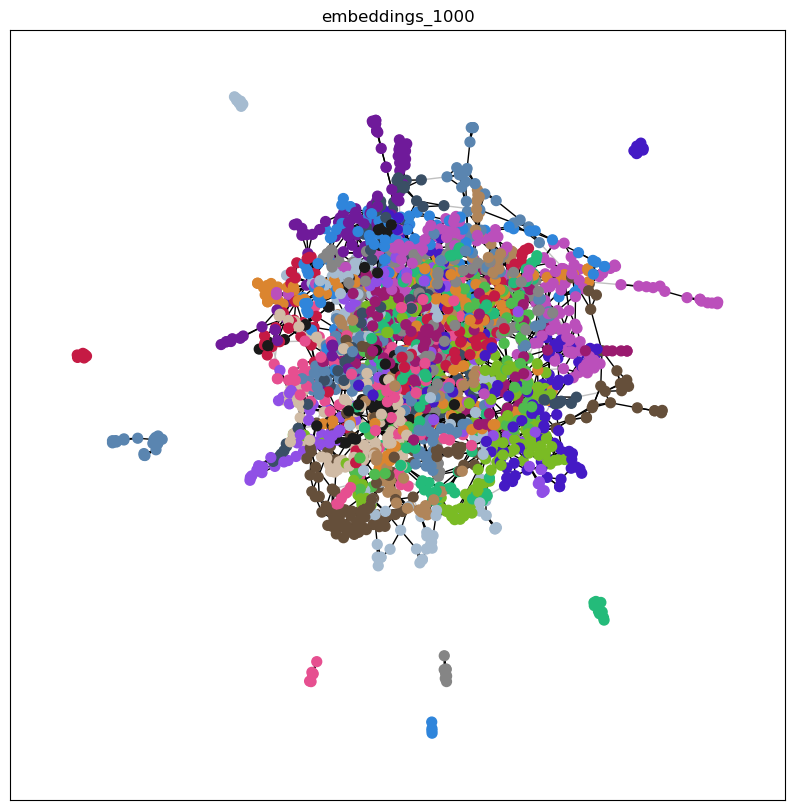

The KNN graph has 33 communities.


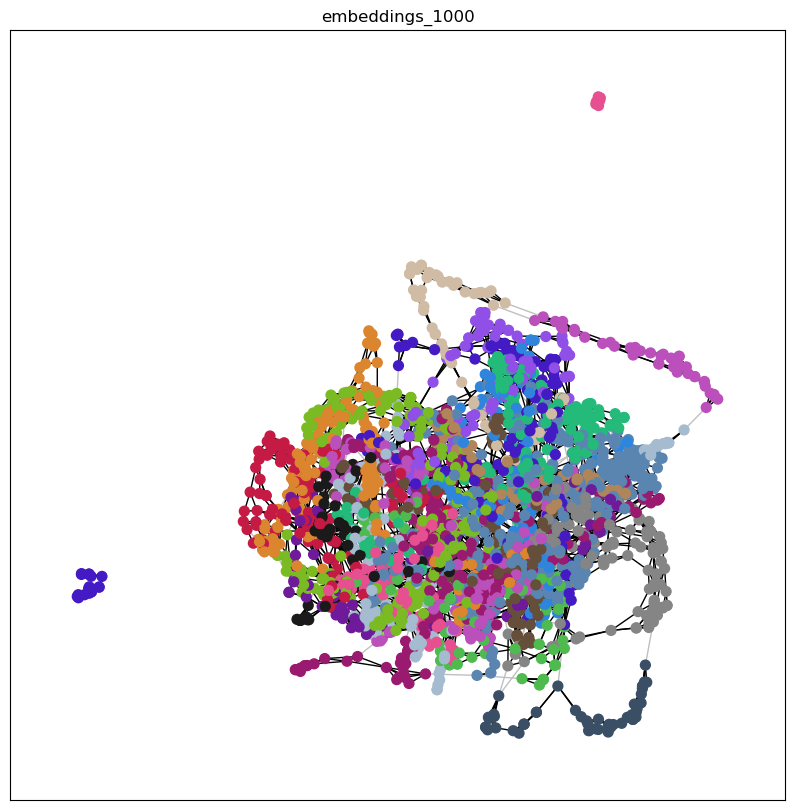

The KNN graph has 24 communities.


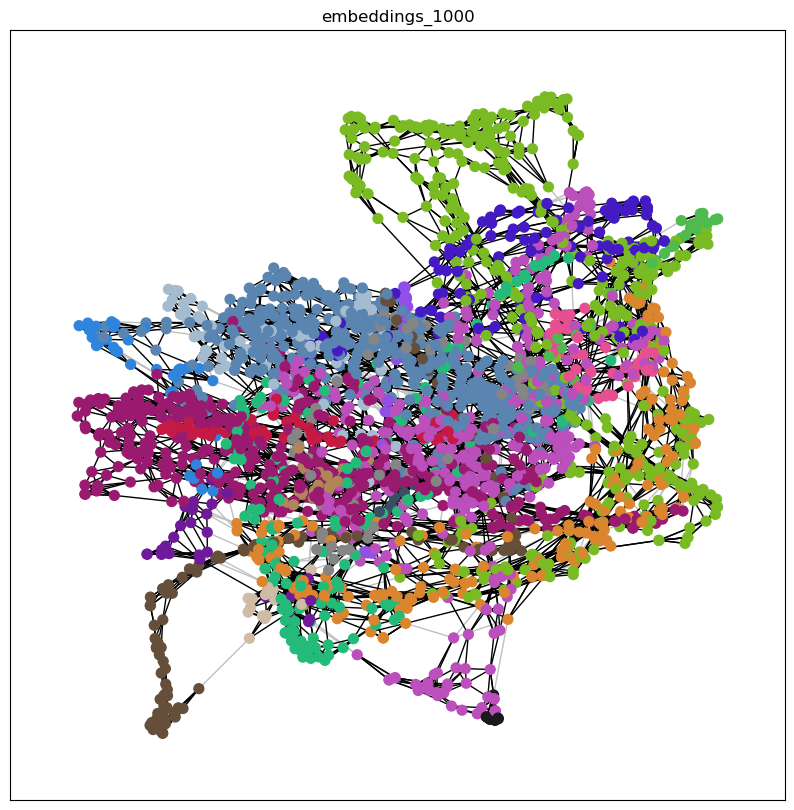

The KNN graph has 23 communities.


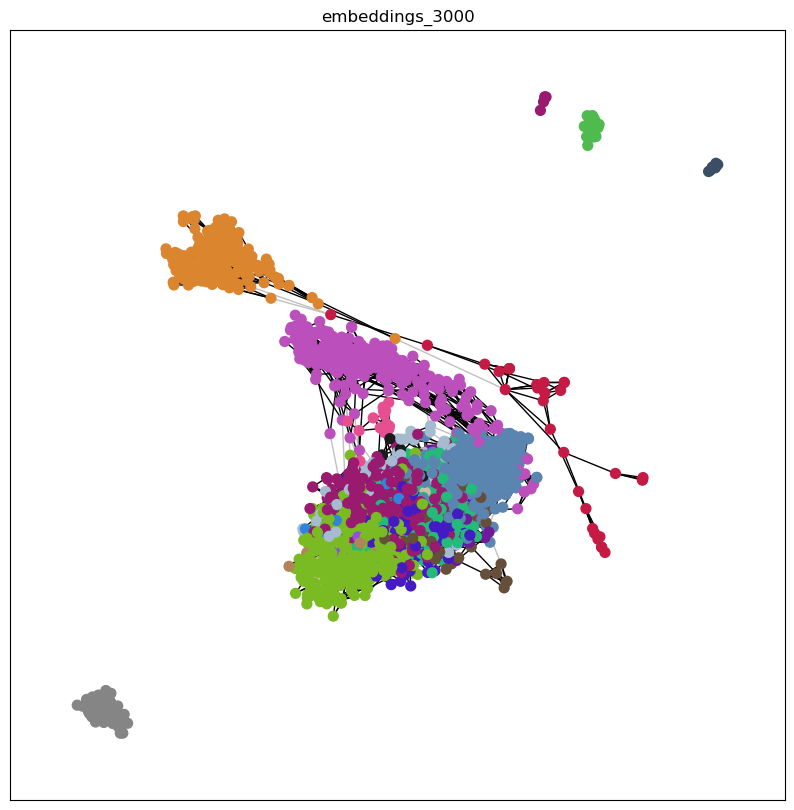

The KNN graph has 18 communities.


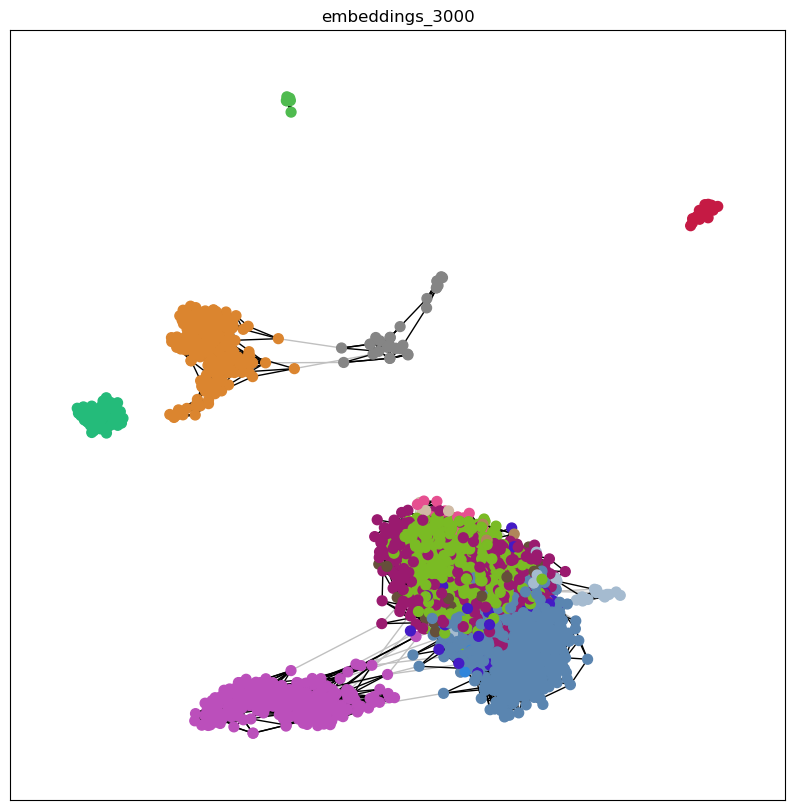

The KNN graph has 13 communities.


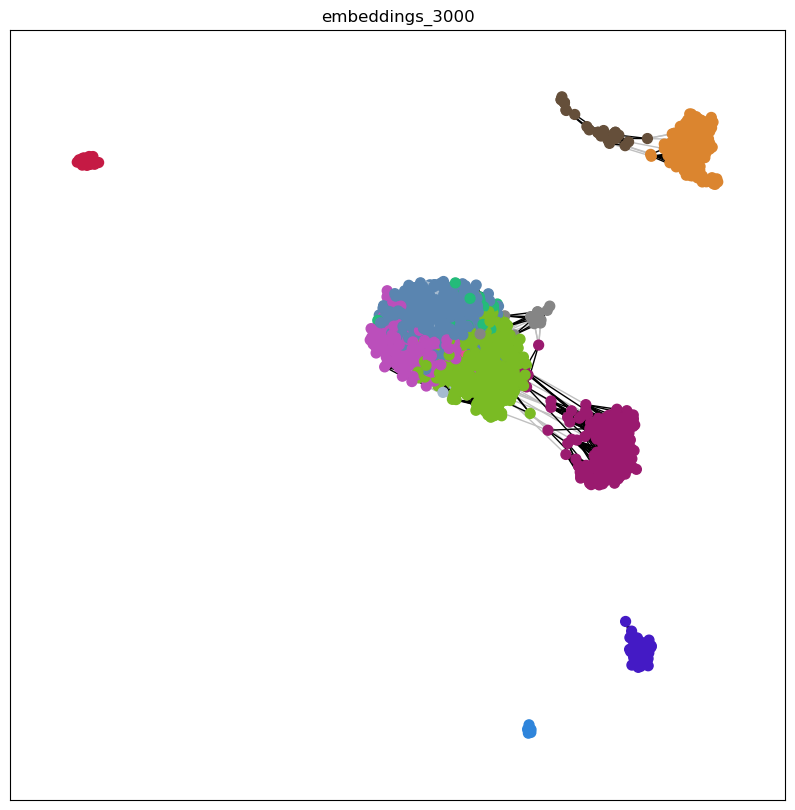

The KNN graph has 21 communities.


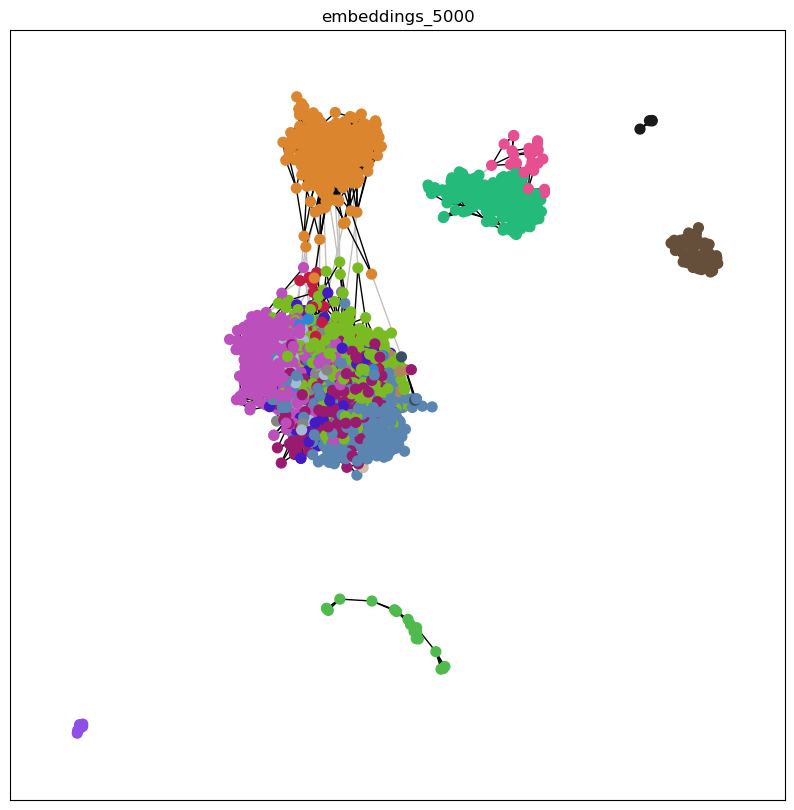

The KNN graph has 13 communities.


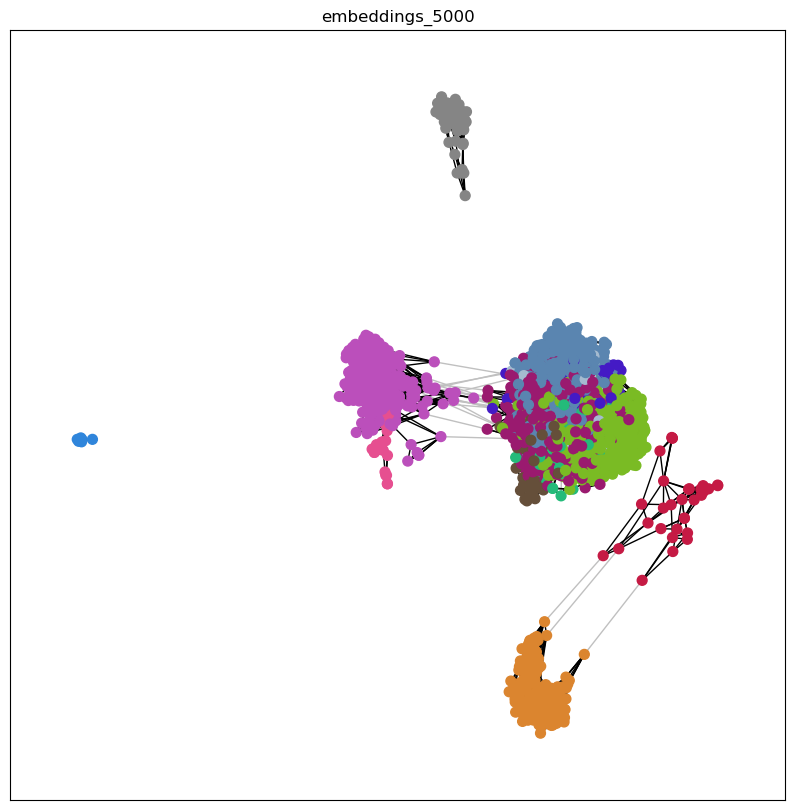

The KNN graph has 13 communities.


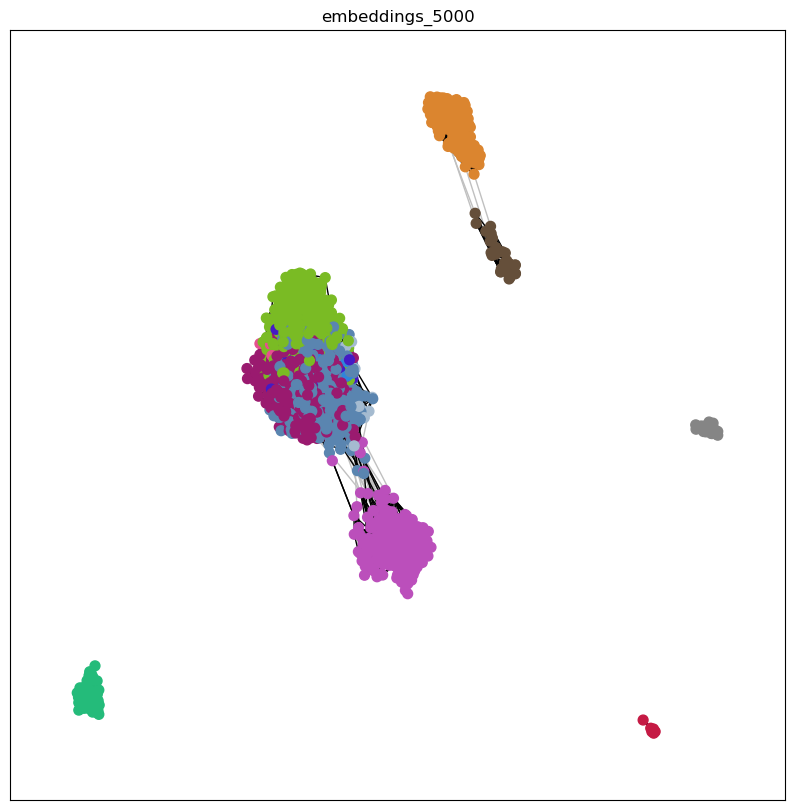

The KNN graph has 16 communities.


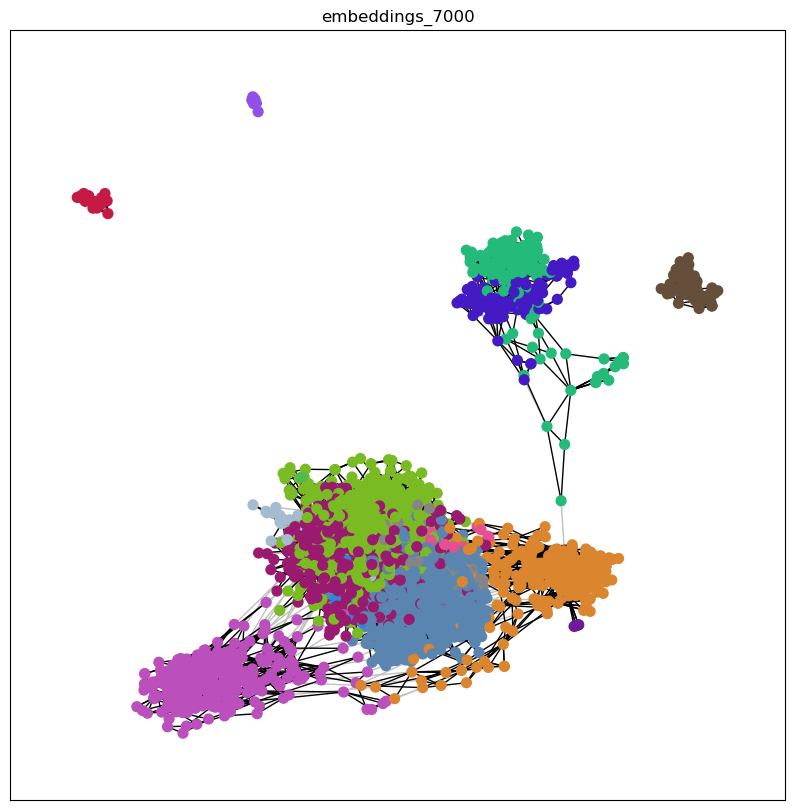

The KNN graph has 13 communities.


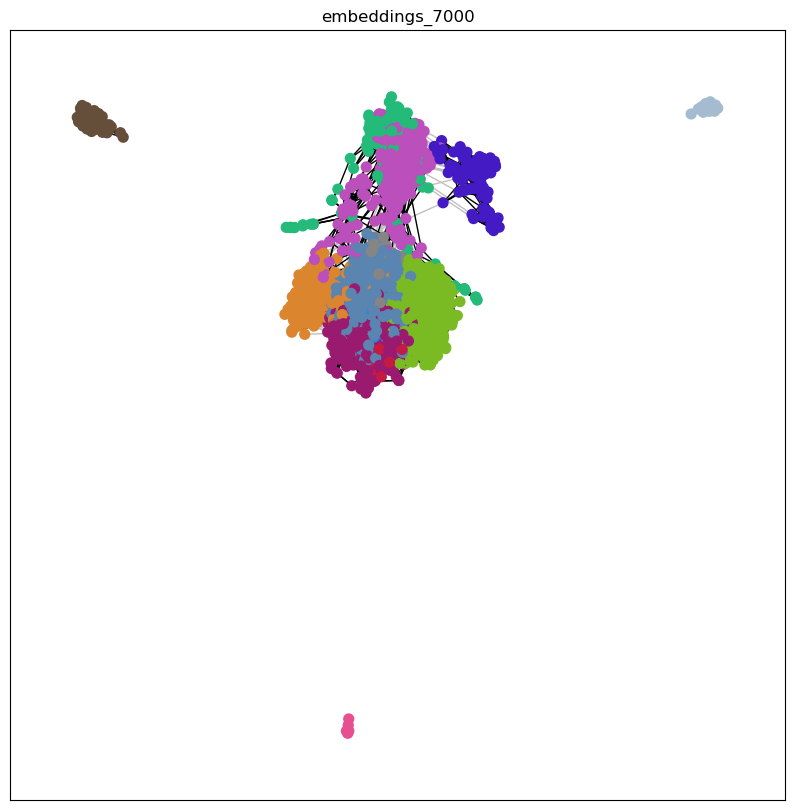

The KNN graph has 9 communities.


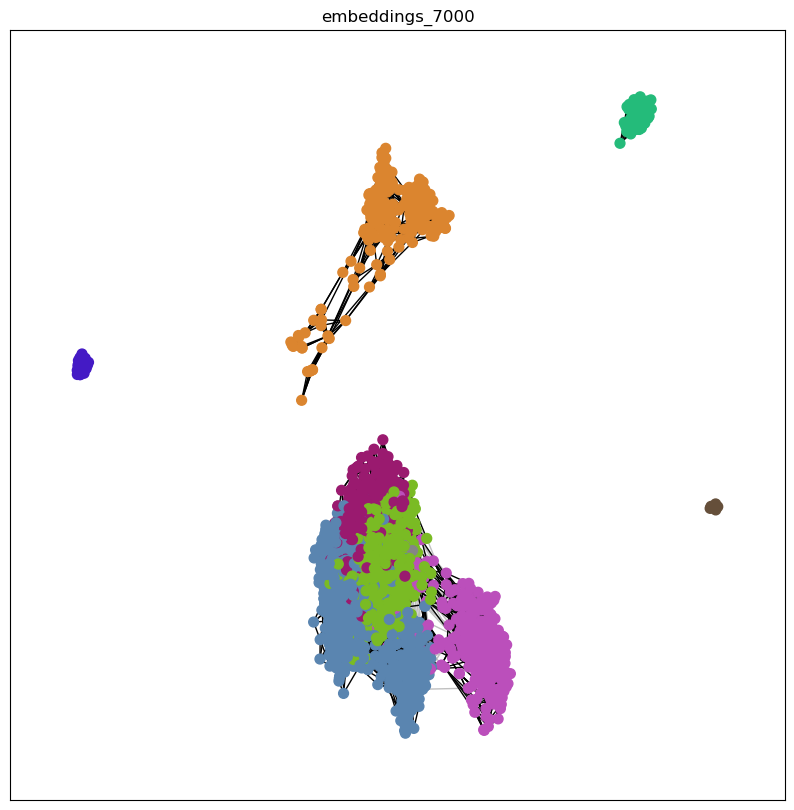

The KNN graph has 17 communities.


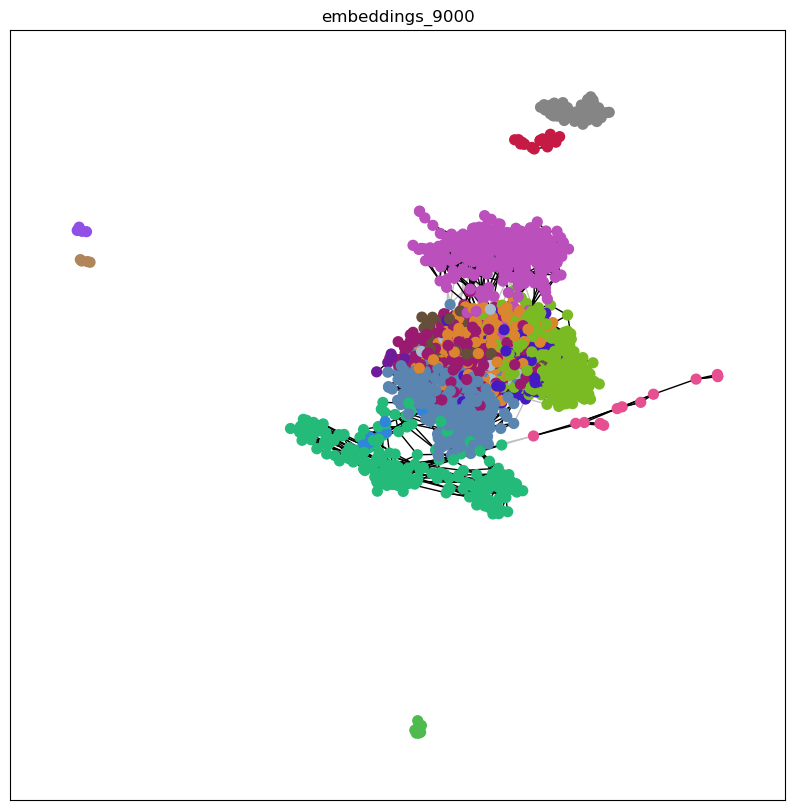

The KNN graph has 12 communities.


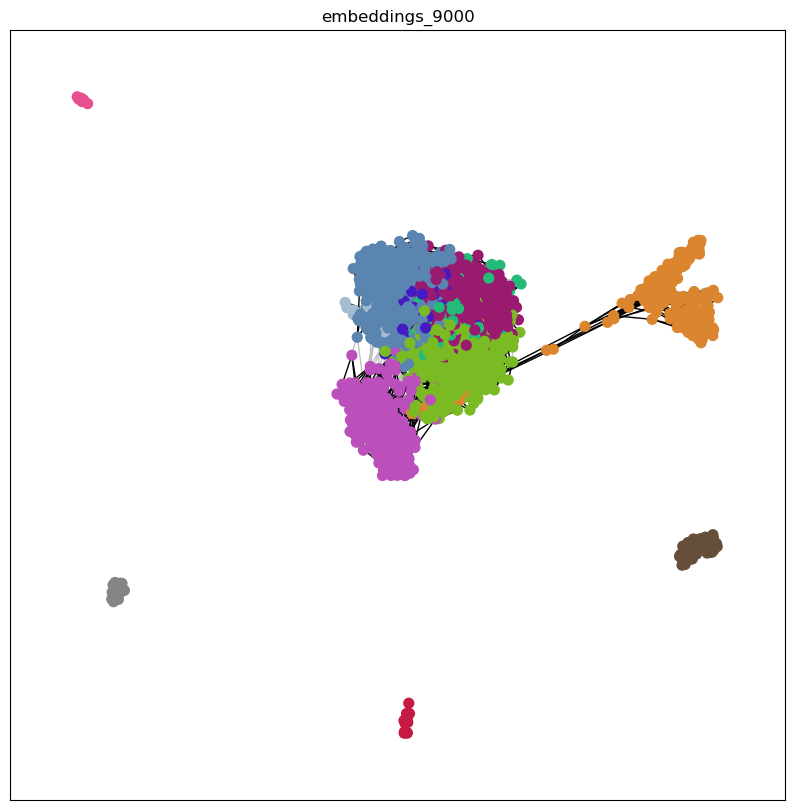

The KNN graph has 12 communities.


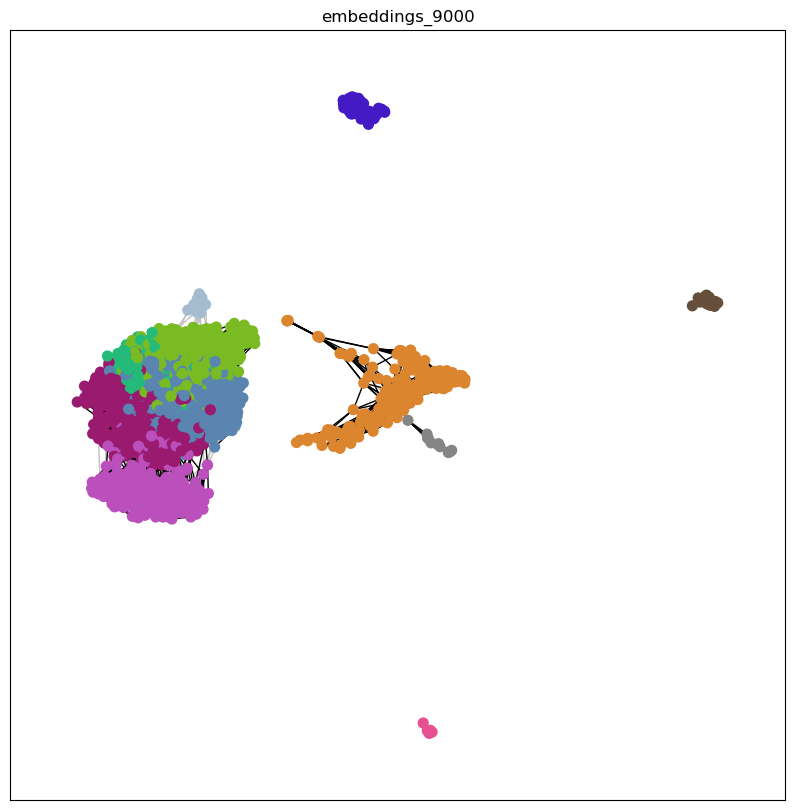

The KNN graph has 13 communities.


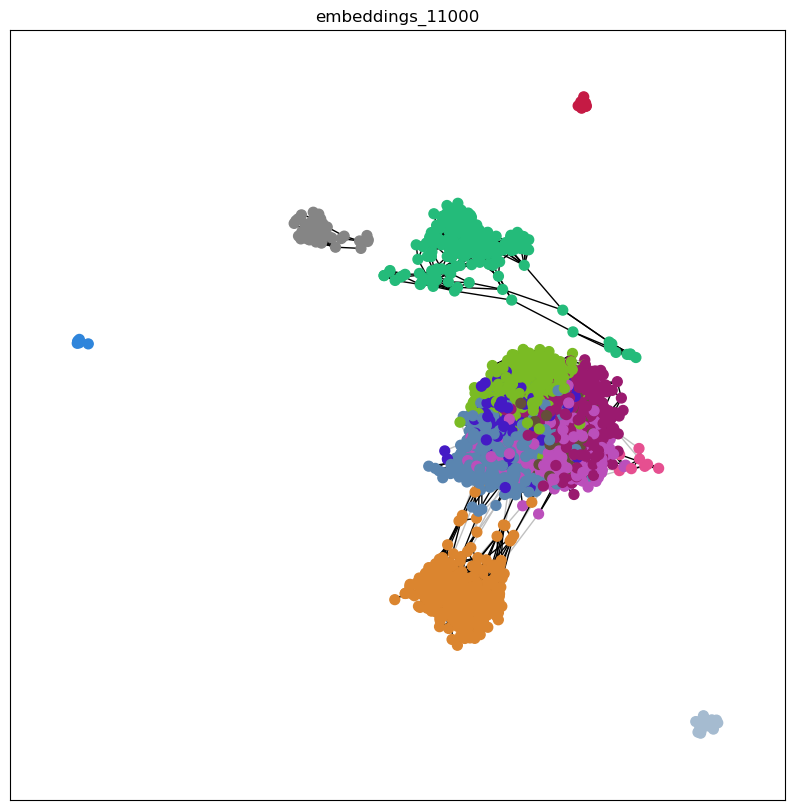

The KNN graph has 11 communities.


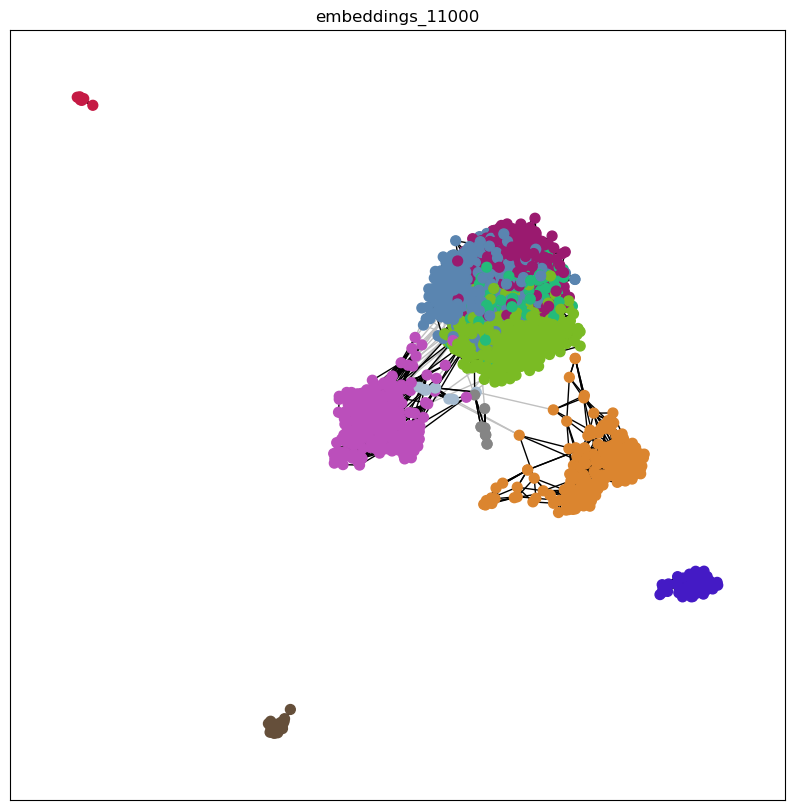

The KNN graph has 10 communities.


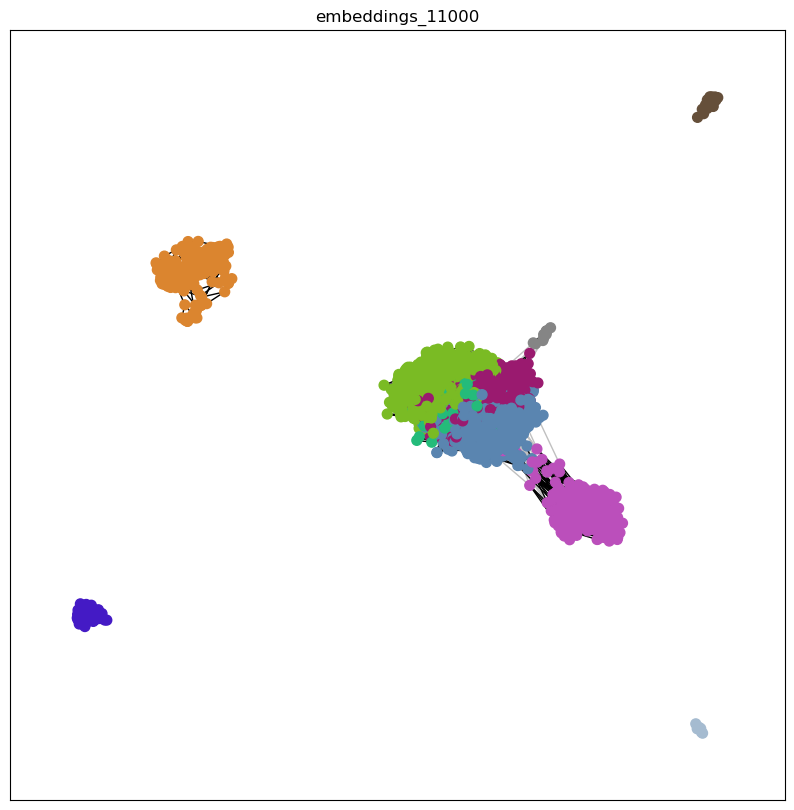

The KNN graph has 16 communities.


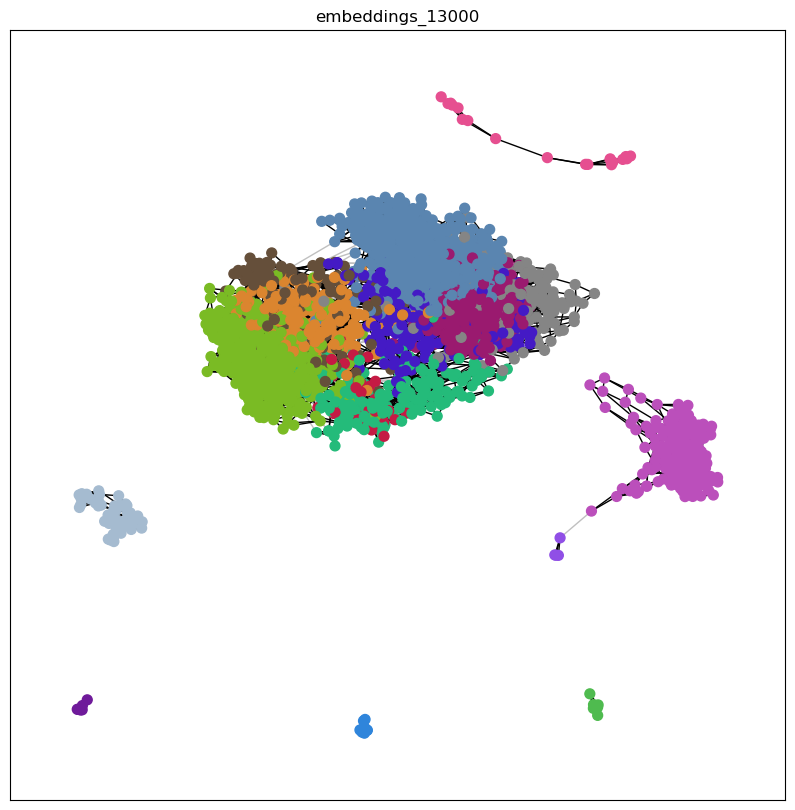

The KNN graph has 12 communities.


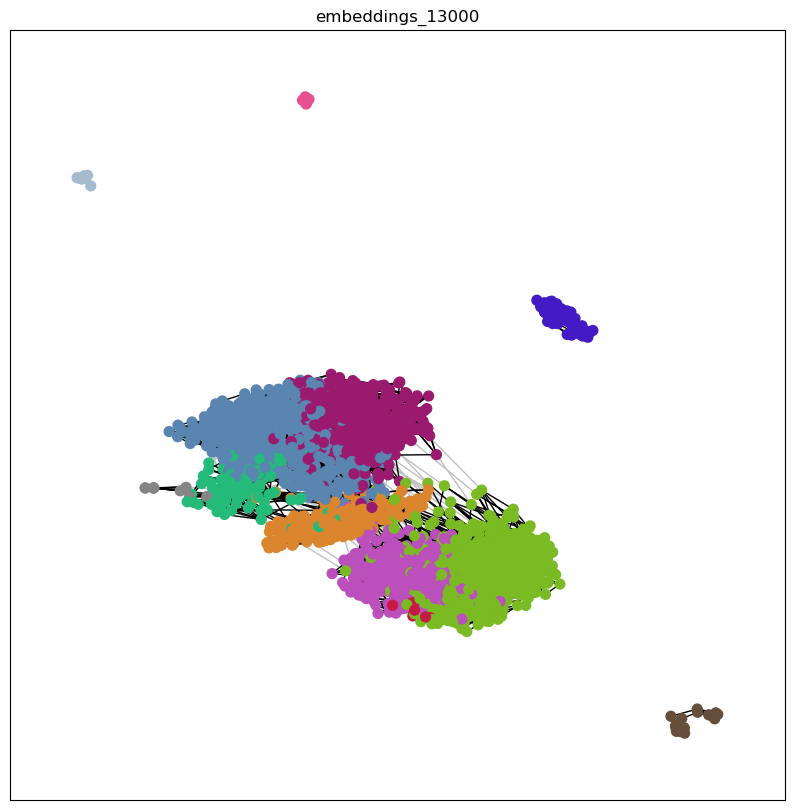

The KNN graph has 10 communities.


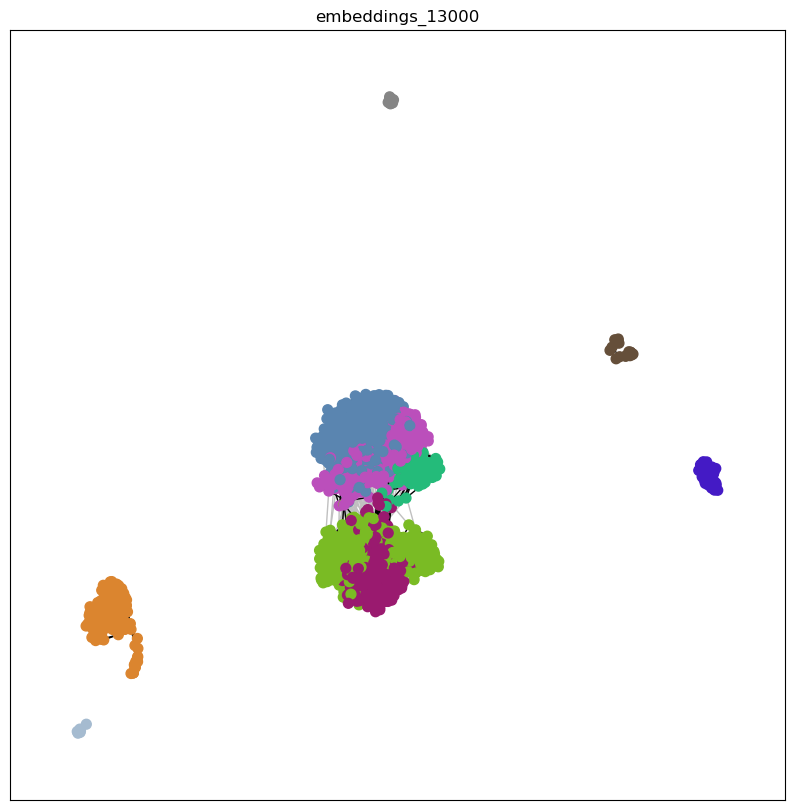

The KNN graph has 18 communities.


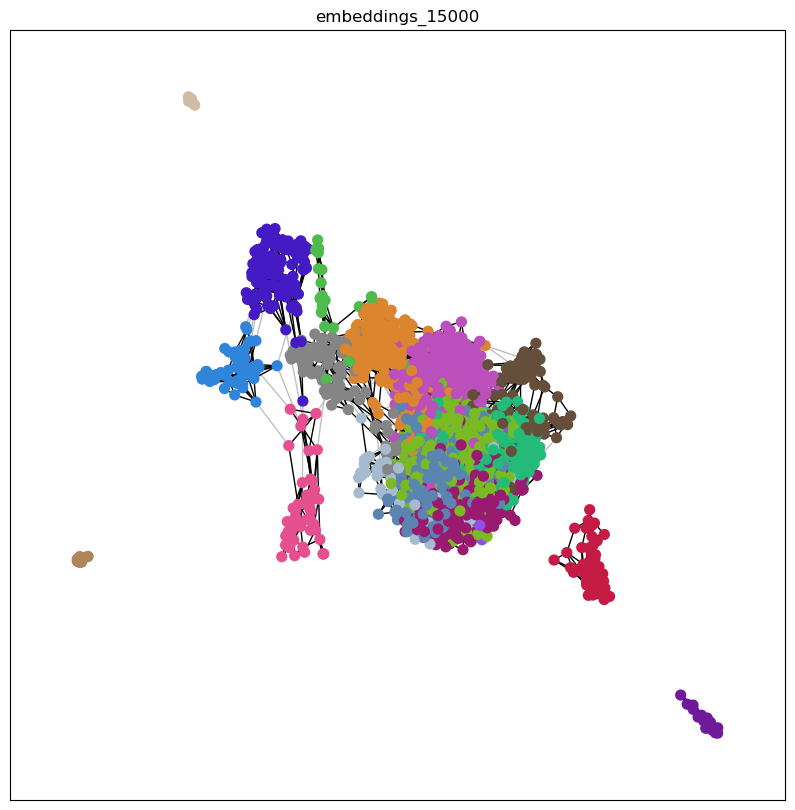

The KNN graph has 13 communities.


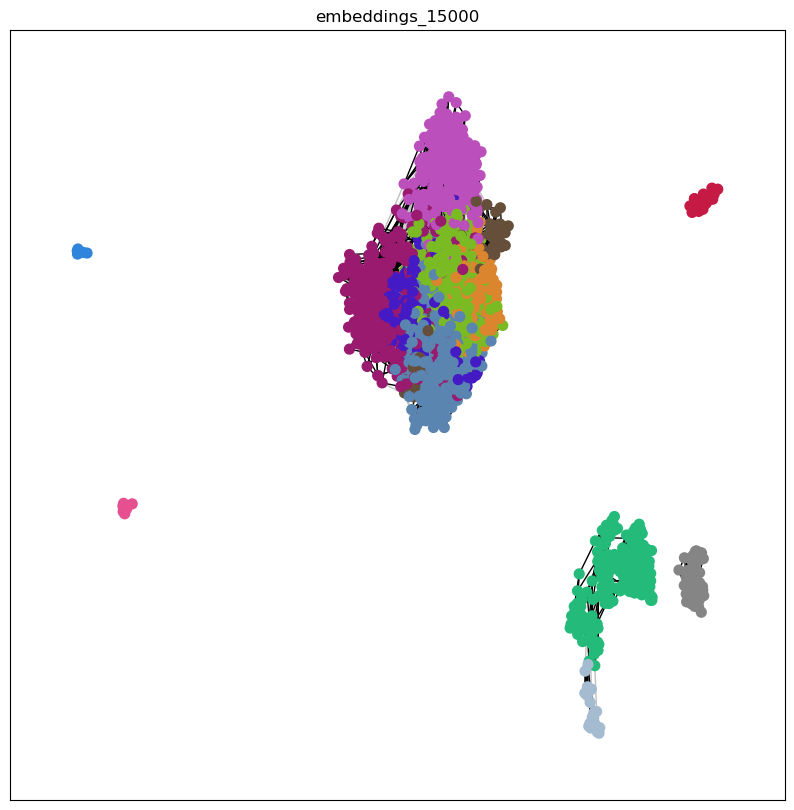

The KNN graph has 11 communities.


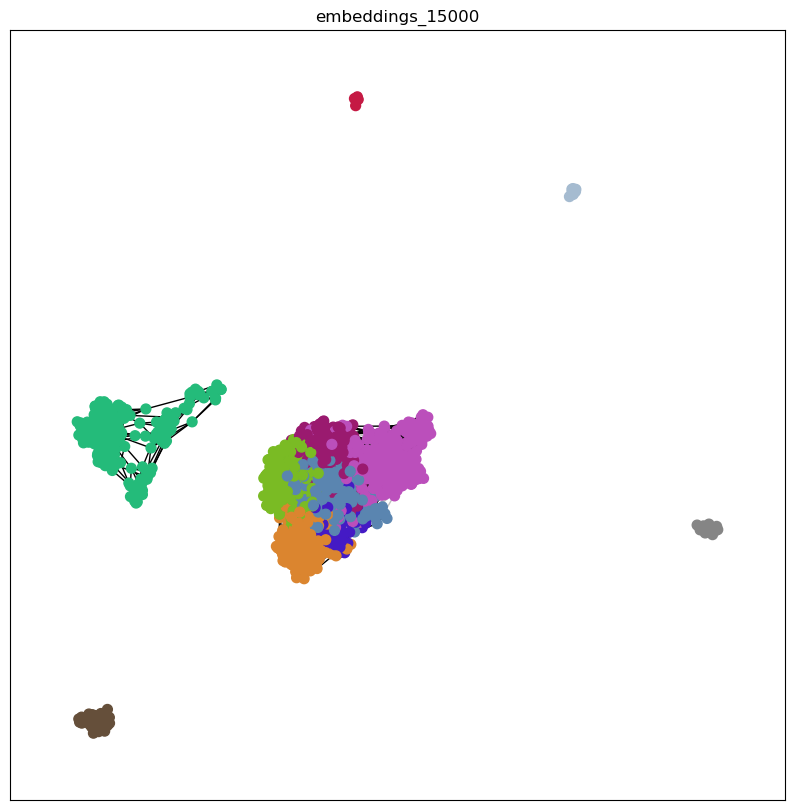

The KNN graph has 17 communities.


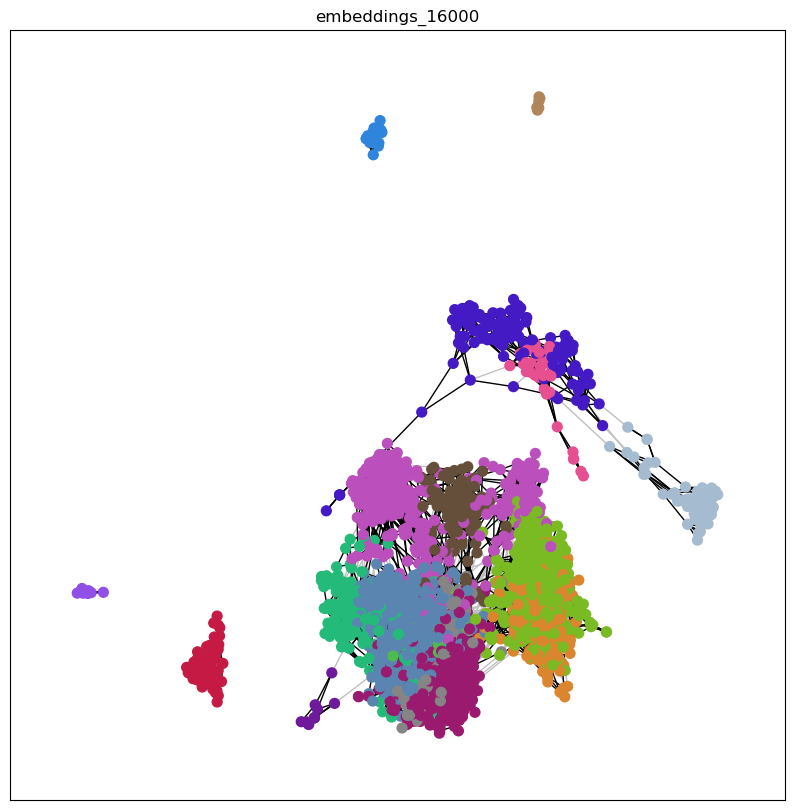

The KNN graph has 14 communities.


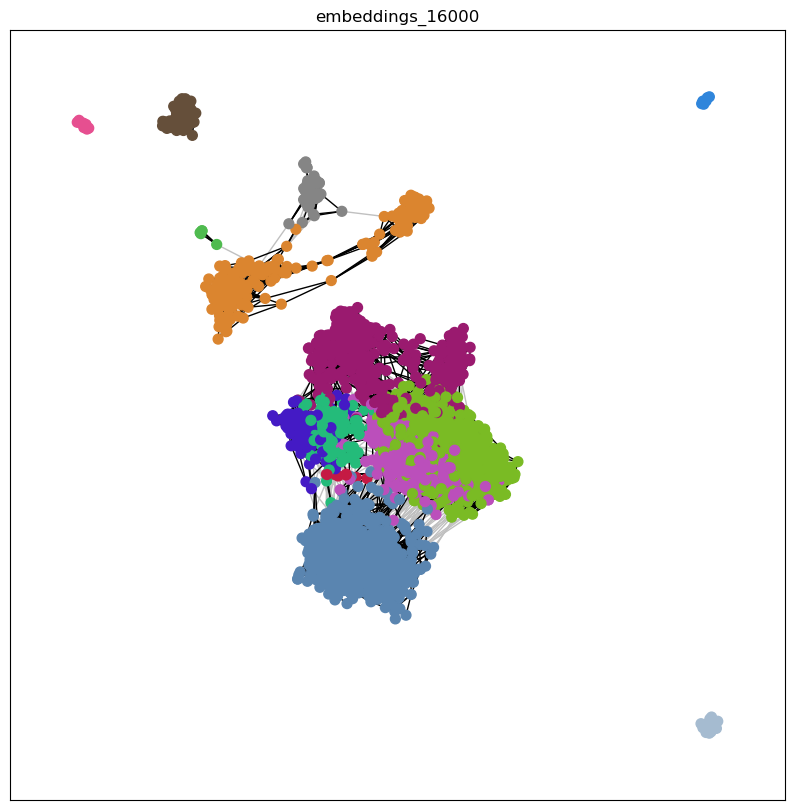

The KNN graph has 12 communities.


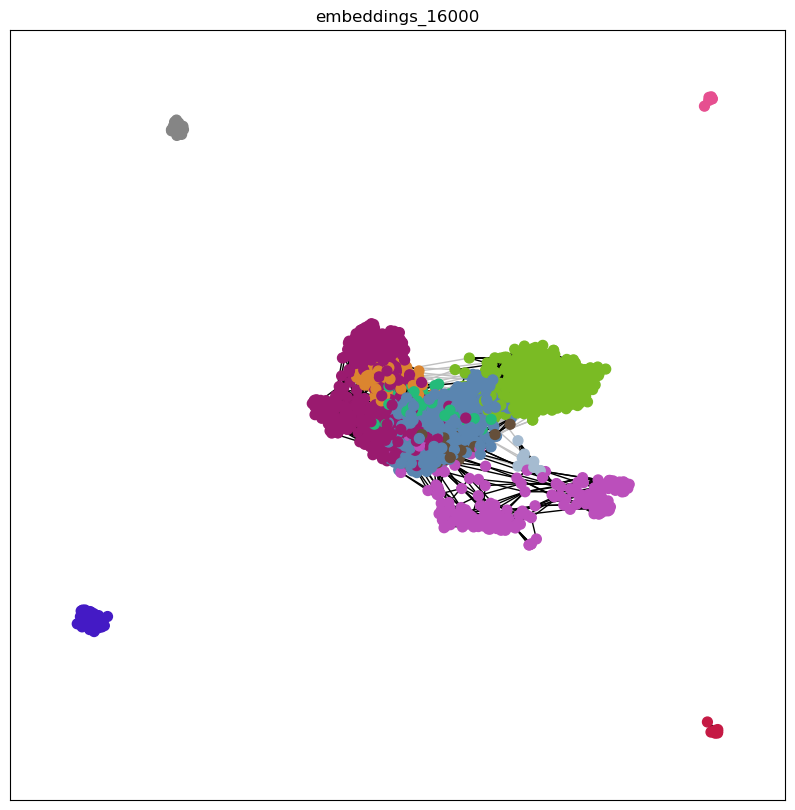

In [30]:
# experiment using different paramenter
Use_Cats = True
cos_or_L2 = 'cos' # ['cos', 'L2']
K_values = [3,4,5]
nHops_values = [3,4]

embedding_name = ['embeddings_1000', 'embeddings_3000','embeddings_5000','embeddings_7000','embeddings_9000', 'embeddings_11000', 'embeddings_13000', 'embeddings_15000','embeddings_16000']
embedding_file = ["embeddings_1000.txt", "embeddings_3000.txt","embeddings_5000.txt","embeddings_7000.txt","embeddings_9000.txt", "embeddings_11000.txt", "embeddings_13000.txt", "embeddings_15000.txt","embeddings_16000.txt"]
result={}
Object = KNN()
for embedding in embedding_name:
    
    for k in K_values:
        
        for nHops in nHops_values:
            file_name = [path+"/"+embedding + ".txt"]
            # RKNN, RKNN properties, KNN Scores, sorted documents w.r.t # neighbors
            Dict_top_k, R_KNN_Properties, KNN_scores, keys = Create_RKNN(Object, Docs_with_top_phrases, [embedding],
                                                                         file_name, cos_or_L2, nHops, k, Doc_keyphrase, df_phrases)

            least_neighbors = keys[:(len(keys)*2//100)]
            most_neighbors = keys[-(len(keys)*2//100):]
            
            # Find common labels
            result.setdefault(k, {}).setdefault(nHops, {}).setdefault(embedding, {})['most_neighbor_common_key_phrases_of_rknn'] = get_common_key_phrases_from_nodes(most_neighbors,R_KNN_Properties)
            result[k][nHops][embedding]['least_neighbor_common_key_phrases_of_rknn'] = get_common_key_phrases_from_nodes(least_neighbors,R_KNN_Properties)

        #@title Community
        C = Community()
        graph_temp, community_temp = C.Community_Detection(all_graphs[embedding]['df_graph'], all_graphs[embedding]['df_similarty'], embedding, Resolution=1)
        community_max_common_key_phrases = get_common_key_phrases_from_community(community_temp[:5], Doc_keyphrase)
        community_min_common_key_phrases = get_common_key_phrases_from_community(community_temp[-5:], Doc_keyphrase)

        #30%
        numOfComm = (len(community_temp)*30//100)
        community_max_common_key_phrases_30 = get_common_key_phrases_from_community(community_temp[:numOfComm], Doc_keyphrase)
        community_min_common_key_phrases_30 = get_common_key_phrases_from_community(community_temp[-numOfComm:], Doc_keyphrase)

        for nHops in nHops_values:
            result[k][nHops][embedding]['community_max_common_key_phrases'] = community_max_common_key_phrases
            result[k][nHops][embedding]['community_min_common_key_phrases'] = community_min_common_key_phrases
            #30
            result[k][nHops][embedding]['community_max_common_key_phrases_30'] = community_max_common_key_phrases_30
            result[k][nHops][embedding]['community_min_common_key_phrases_30'] = community_min_common_key_phrases_30            

In [31]:
# print(result)
result_columns=['k', 'nHops' , 'embedding','most_neighbor_common_key_phrases_of_rknn',
                'least_neighbor_common_key_phrases_of_rknn',
                'community_max_common_key_phrases','community_min_common_key_phrases',
                'community_max_vs_most_neighbour','community_min_vs_least_neighbour']
#for plot
y=[]

result_data = []
for k in result:
    for nhops in result[k]:
        for emb in result[k][nhops]:
            
            community_max_vs_most_neighbour = get_intersected_values({"max":result[k][nhops][emb]['community_max_common_key_phrases'],"most":result[k][nhops][emb]['most_neighbor_common_key_phrases_of_rknn']})
            community_min_vs_least_neighbour = get_intersected_values({"max":result[k][nhops][emb]['community_min_common_key_phrases'],"most":result[k][nhops][emb]['least_neighbor_common_key_phrases_of_rknn']})
            result_data.append([k,nhops,emb,
                                len(result[k][nhops][emb]['most_neighbor_common_key_phrases_of_rknn']),
                                len(result[k][nhops][emb]['least_neighbor_common_key_phrases_of_rknn']),
                                len(result[k][nhops][emb]['community_max_common_key_phrases']),
                                len(result[k][nhops][emb]['community_min_common_key_phrases']),
                                len(community_max_vs_most_neighbour),
                                len(community_min_vs_least_neighbour)
                               ])
            
result_df = pd.DataFrame(result_data,columns=result_columns)        
# result_df


### plot number of Common key-phrase and Checkpoint on rKNN and  Community 

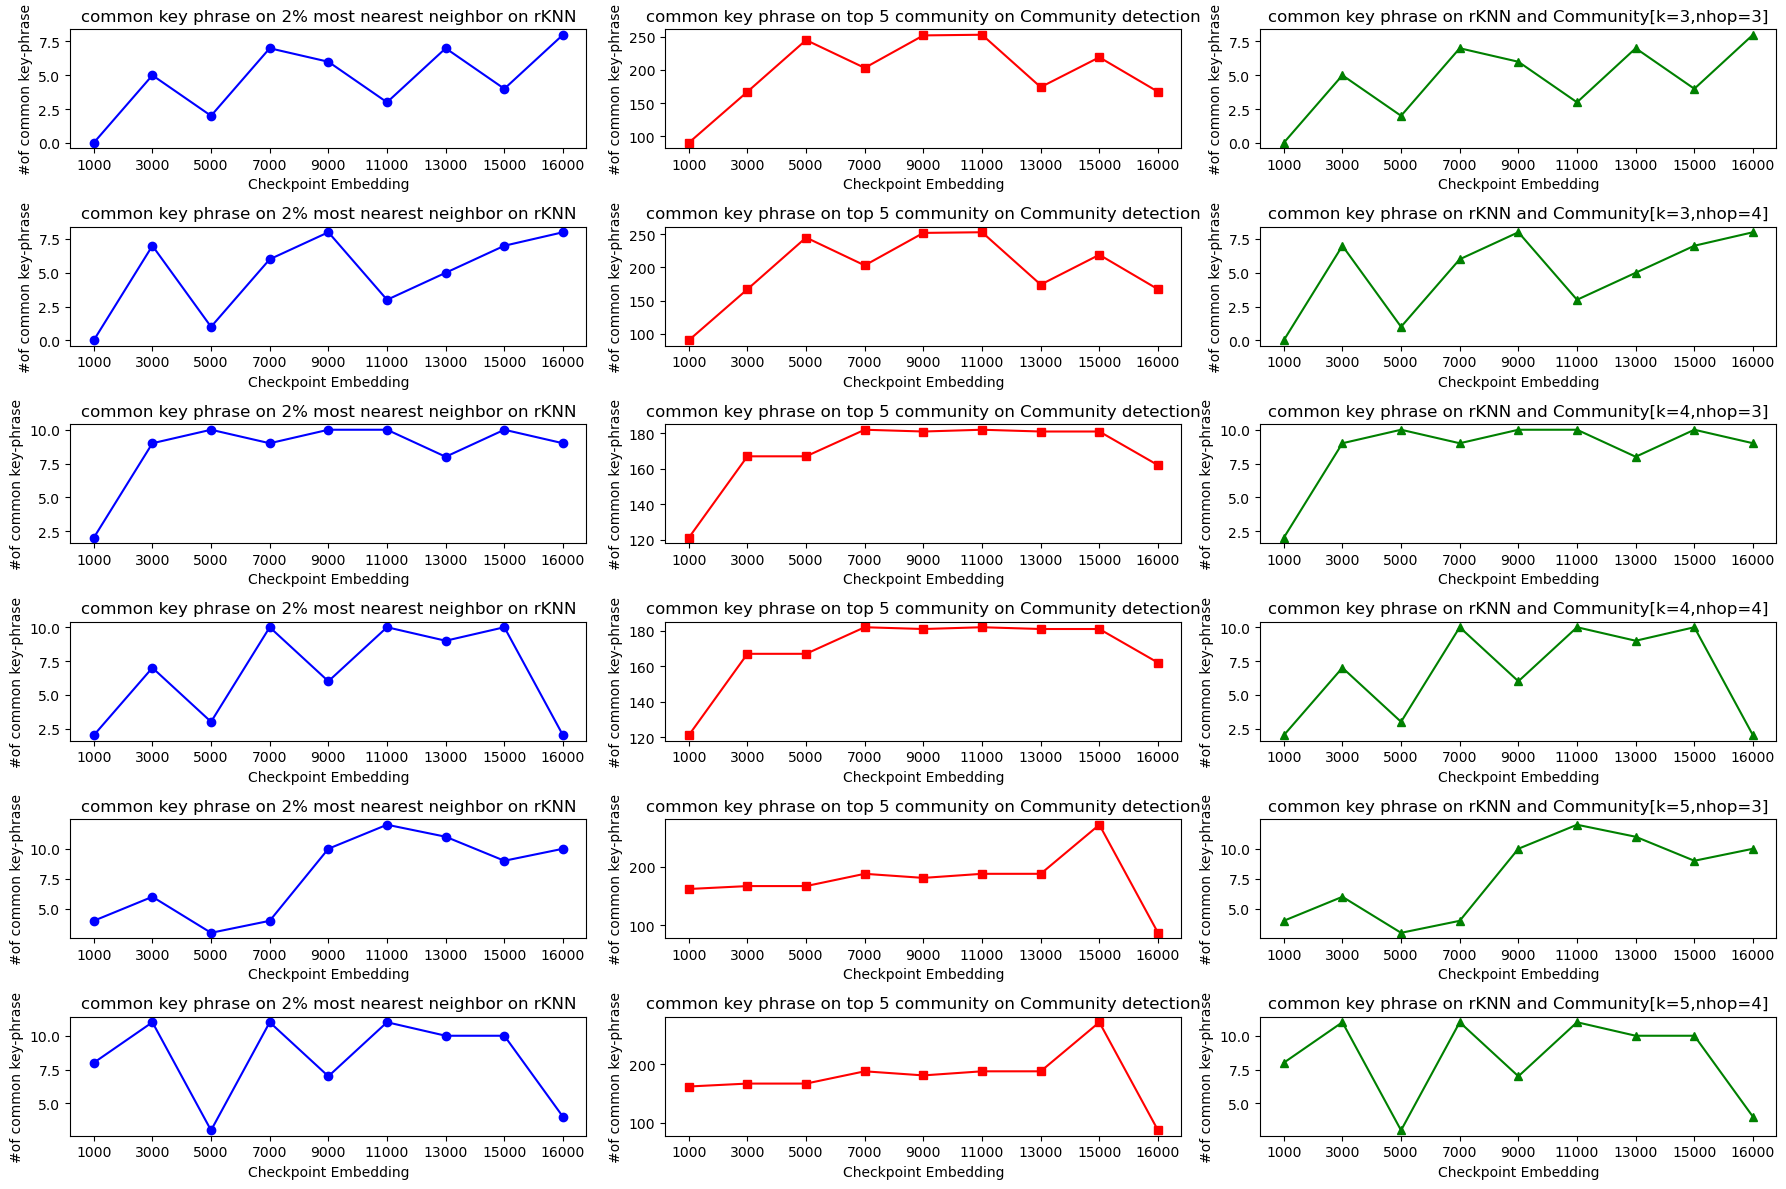

In [32]:
import matplotlib.pyplot as plt
# nHops_values = [3,4]
# K_values = [3,4,5]
plt_count = len(K_values)*len(nHops_values)
# Create a figure with three subplots 
fig, axs = plt.subplots(plt_count, 3, figsize=(18, 12))

x = ['1000', '3000', '5000', '7000', '9000', '11000', '13000', '15000', '16000']
plot_line =0
for k in K_values:
    for nhops in nHops_values:
        # print(f'For k={k} and nHop={nhops} : ')
        
        temp = result_df[(result_df['k'] == k) & (result_df['nHops'] == nhops)]
        y_rknn, y_community, y_common = [],[],[]
        for index,row in temp.iterrows():
            # print(row)
            y_rknn.append(row['most_neighbor_common_key_phrases_of_rknn'])
            y_community.append(row['community_max_common_key_phrases'])
            y_common.append(row['community_max_vs_most_neighbour'])

        # Plot for the first subplot
        axs[plot_line][0].plot(x, y_rknn, marker='o', linestyle='-', color='b')
        axs[plot_line][0].set_title('common key phrase on 2% most nearest neighbor on rKNN')
        axs[plot_line][0].set_xlabel('Checkpoint Embedding')
        axs[plot_line][0].set_ylabel('#of common key-phrase')

        # Plot for the second subplot
        axs[plot_line][1].plot(x, y_community, marker='s', linestyle='-', color='r')
        axs[plot_line][1].set_title('common key phrase on top 5 community on Community detection')
        axs[plot_line][1].set_xlabel('Checkpoint Embedding')
        axs[plot_line][1].set_ylabel('#of common key-phrase')

        # Plot for the third subplot
        axs[plot_line][2].plot(x, y_common, marker='^', linestyle='-', color='g')
        axs[plot_line][2].set_title(f'common key phrase on rKNN and Community[k={k},nhop={nhops}]')
        axs[plot_line][2].set_xlabel('Checkpoint Embedding')
        axs[plot_line][2].set_ylabel('#of common key-phrase')
        
        plot_line = plot_line +1
# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

### calculate new result_df from result data

In [33]:
result_columns=['k', 'nHops' , 'embedding','most_neighbor_common_key_phrases_of_rknn',
                'least_neighbor_common_key_phrases_of_rknn',
                'community_max_common_key_phrases','community_min_common_key_phrases',
                'community_max_common_key_phrases_30','community_min_common_key_phrases_30',
               ]

result_data = []
for k in result:
    for nhops in result[k]:
        for emb in result[k][nhops]:
            
            # community_max_vs_most_neighbour = get_intersected_values({"max":result[k][nhops][emb]['community_max_common_key_phrases'],"most":result[k][nhops][emb]['most_neighbor_common_key_phrases_of_rknn']})
            # community_min_vs_least_neighbour = get_intersected_values({"max":result[k][nhops][emb]['community_min_common_key_phrases'],"most":result[k][nhops][emb]['least_neighbor_common_key_phrases_of_rknn']})
            result_data.append([k,nhops,emb,
                                len(result[k][nhops][emb]['most_neighbor_common_key_phrases_of_rknn']),
                                len(result[k][nhops][emb]['least_neighbor_common_key_phrases_of_rknn']),
                                len(result[k][nhops][emb]['community_max_common_key_phrases']),
                                len(result[k][nhops][emb]['community_min_common_key_phrases']),
                                len(result[k][nhops][emb]['community_max_common_key_phrases_30']),
                                len(result[k][nhops][emb]['community_min_common_key_phrases_30']),
                               ])
            
result_df = pd.DataFrame(result_data,columns=result_columns)        
result_df

k  nHops         embedding  most_neighbor_common_key_phrases_of_rknn  \
0   3      3   embeddings_1000                                         0   
1   3      3   embeddings_3000                                         5   
2   3      3   embeddings_5000                                         2   
3   3      3   embeddings_7000                                         7   
4   3      3   embeddings_9000                                         6   
5   3      3  embeddings_11000                                         3   
6   3      3  embeddings_13000                                         7   
7   3      3  embeddings_15000                                         4   
8   3      3  embeddings_16000                                         8   
9   3      4   embeddings_1000                                         0   
10  3      4   embeddings_3000                                         7   
11  3      4   embeddings_5000                                         1   
12  3      4   embeddings_7000                                         6   
13  3      4   embeddings_9000                                         8   
14  3      4  embeddings_11000                                         3   
15  3      4  embeddings_13000                                         5   
16  3      4  embeddings_15000                                         7   
17  3      4  embeddings_16000                                         8   
18  4      3   embeddings_1000                                         2   
19  4      3   embeddings_3000                                         9   
20  4      3   embeddings_5000                                        10   
21  4      3   embeddings_7000                                         9   
22  4      3   embeddings_9000                                        10   
23  4      3  embeddings_11000                                        10   
24  4      3  embeddings_13000                                         8   
25  4      3  embeddings_15000                                        10   
26  4      3  embeddings_16000                                         9   
27  4      4   embeddings_1000                                         2   
28  4      4   embeddings_3000                                         7   
29  4      4   embeddings_5000                                         3   
30  4      4   embeddings_7000                                        10   
31  4      4   embeddings_9000                                         6   
32  4      4  embeddings_11000                                        10   
33  4      4  embeddings_13000                                         9   
34  4      4  embeddings_15000                                        10   
35  4      4  embeddings_16000                                         2   
36  5      3   embeddings_1000                                         4   
37  5      3   embeddings_3000                                         6   
38  5      3   embeddings_5000                                         3   
39  5      3   embeddings_7000                                         4   
40  5      3   embeddings_9000                                        10   
41  5      3  embeddings_11000                                        12   
42  5      3  embeddings_13000                                        11   
43  5      3  embeddings_15000                                         9   
44  5      3  embeddings_16000                                        10   
45  5      4   embeddings_1000                                         8   
46  5      4   embeddings_3000                                        11   
47  5      4   embeddings_5000                                         3   
48  5      4   embeddings_7000                                        11   
49  5      4   embeddings_9000                                         7   
50  5      4  embeddings_11000                                        11   
51  5      4  embeddings_13000                      

### plot for new result data

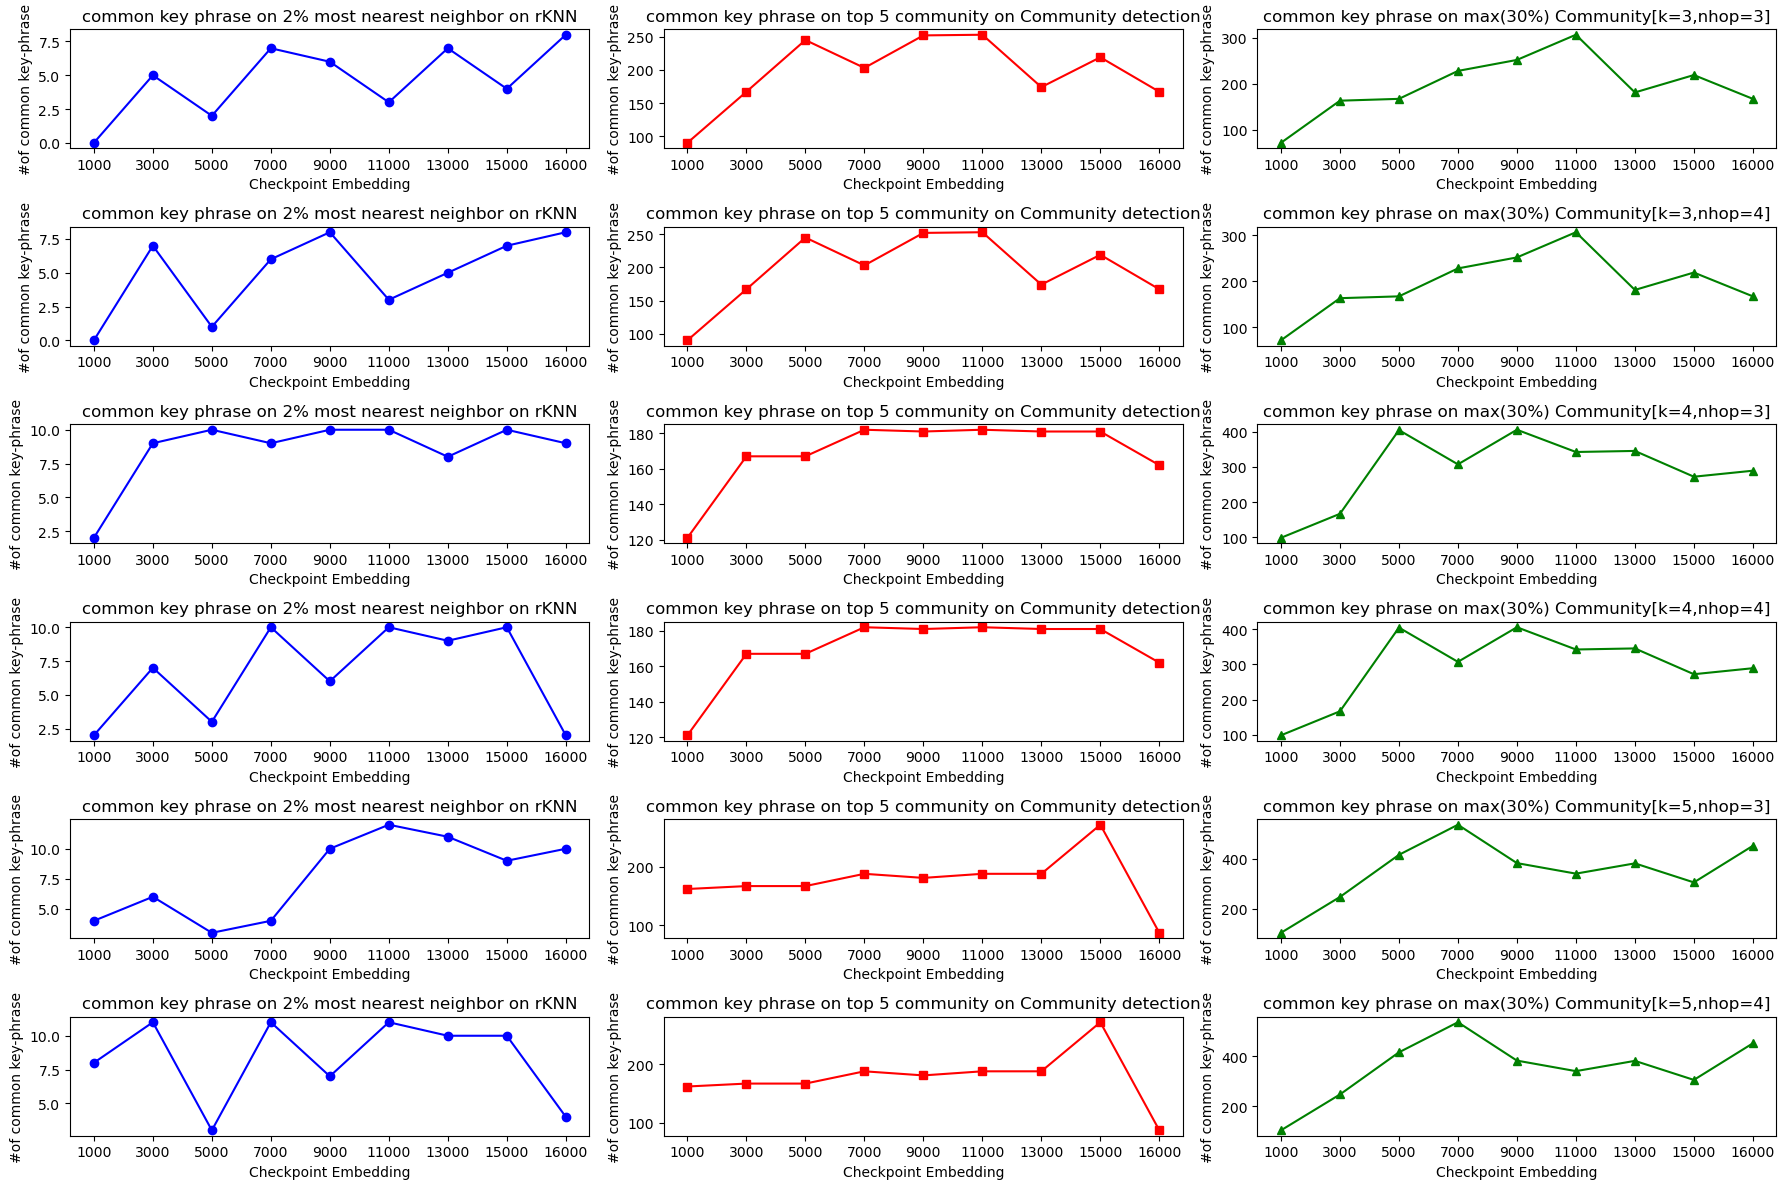

In [34]:
import matplotlib.pyplot as plt
# nHops_values = [3,4]
# K_values = [3,4,5]
plt_count = len(K_values)*len(nHops_values)
# Create a figure with three subplots
fig, axs = plt.subplots(plt_count, 3, figsize=(18, 12))

x = ['1000', '3000', '5000', '7000', '9000', '11000', '13000', '15000', '16000']
plot_line =0
for k in K_values:
    for nhops in nHops_values:
        # print(f'For k={k} and nHop={nhops} : ')
        temp = result_df[(result_df['k'] == k) & (result_df['nHops'] == nhops)]
        y_rknn, y_community, y_community_30, y_common = [],[],[],[]

        for index,row in temp.iterrows():
            y_rknn.append(row['most_neighbor_common_key_phrases_of_rknn'])
            y_community.append(row['community_max_common_key_phrases'])
            y_community_30.append(row['community_max_common_key_phrases_30'])

        # Plot for the first subplot
        axs[plot_line][0].plot(x, y_rknn, marker='o', linestyle='-', color='b')
        axs[plot_line][0].set_title('common key phrase on 2% most nearest neighbor on rKNN')
        axs[plot_line][0].set_xlabel('Checkpoint Embedding')
        axs[plot_line][0].set_ylabel('#of common key-phrase')

        # Plot for the second subplot
        axs[plot_line][1].plot(x, y_community, marker='s', linestyle='-', color='r')
        axs[plot_line][1].set_title('common key phrase on top 5 community on Community detection')
        axs[plot_line][1].set_xlabel('Checkpoint Embedding')
        axs[plot_line][1].set_ylabel('#of common key-phrase')
        
        # Plot for the third subplot 30%
        axs[plot_line][2].plot(x, y_community_30, marker='^', linestyle='-', color='g')
        axs[plot_line][2].set_title(f'common key phrase on max(30%) Community[k={k},nhop={nhops}]')
        axs[plot_line][2].set_xlabel('Checkpoint Embedding')
        axs[plot_line][2].set_ylabel('#of common key-phrase')
        
        
        plot_line = plot_line +1
        
# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

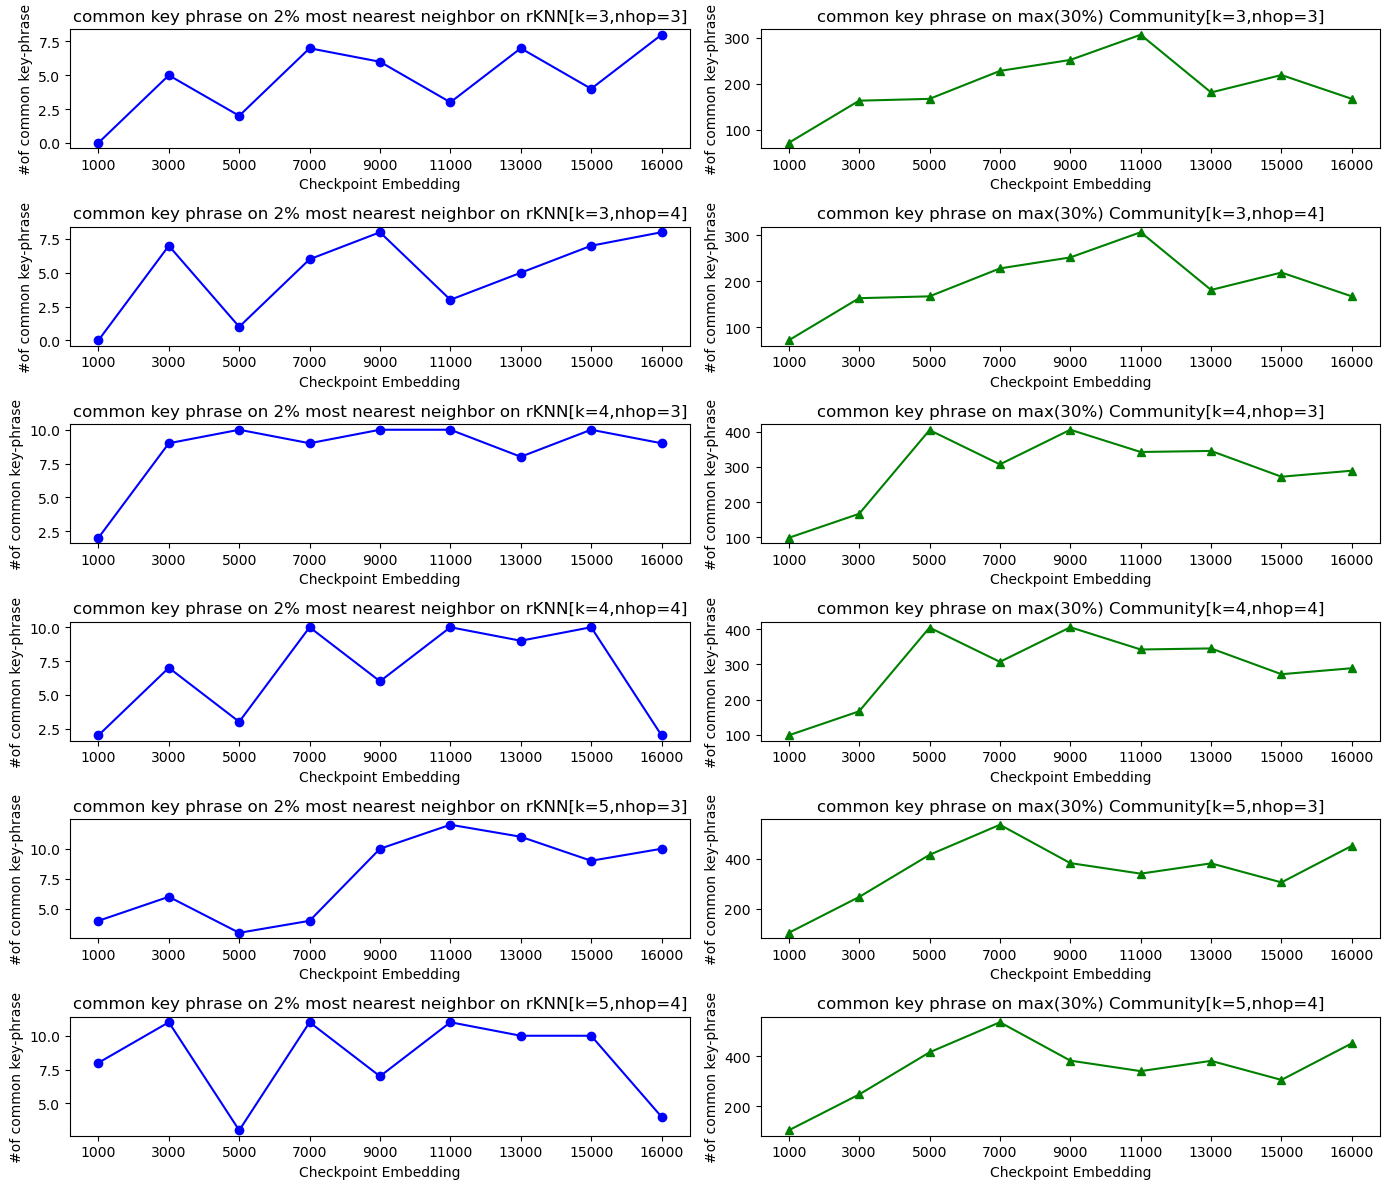

In [35]:
import matplotlib.pyplot as plt
nHops_values = [3,4]
K_values = [3,4,5]
plt_count = len(K_values)*len(nHops_values)
# Create a figure with three subplots
fig, axs = plt.subplots(plt_count, 2, figsize=(14, 12))

x = ['1000', '3000', '5000', '7000', '9000', '11000', '13000', '15000', '16000']
plot_line =0
for k in K_values:
    for nhops in nHops_values:
        # print(f'For k={k} and nHop={nhops} : ')
        
        temp = result_df[(result_df['k'] == k) & (result_df['nHops'] == nhops)]
        y_rknn, y_community_30 = [],[]
        for index,row in temp.iterrows():
            # print(row)
            y_rknn.append(row['most_neighbor_common_key_phrases_of_rknn'])
            y_community_30.append(row['community_max_common_key_phrases_30'])

        # Plot for the first subplot
        axs[plot_line][0].plot(x, y_rknn, marker='o', linestyle='-', color='b')
        axs[plot_line][0].set_title(f'common key phrase on 2% most nearest neighbor on rKNN[k={k},nhop={nhops}]')
        axs[plot_line][0].set_xlabel('Checkpoint Embedding')
        axs[plot_line][0].set_ylabel('#of common key-phrase')

        # Plot for the third subplot 30
        axs[plot_line][1].plot(x, y_community_30, marker='^', linestyle='-', color='g')
        axs[plot_line][1].set_title(f'common key phrase on max(30%) Community[k={k},nhop={nhops}]')
        axs[plot_line][1].set_xlabel('Checkpoint Embedding')
        axs[plot_line][1].set_ylabel('#of common key-phrase')
        
        plot_line = plot_line +1
        
# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

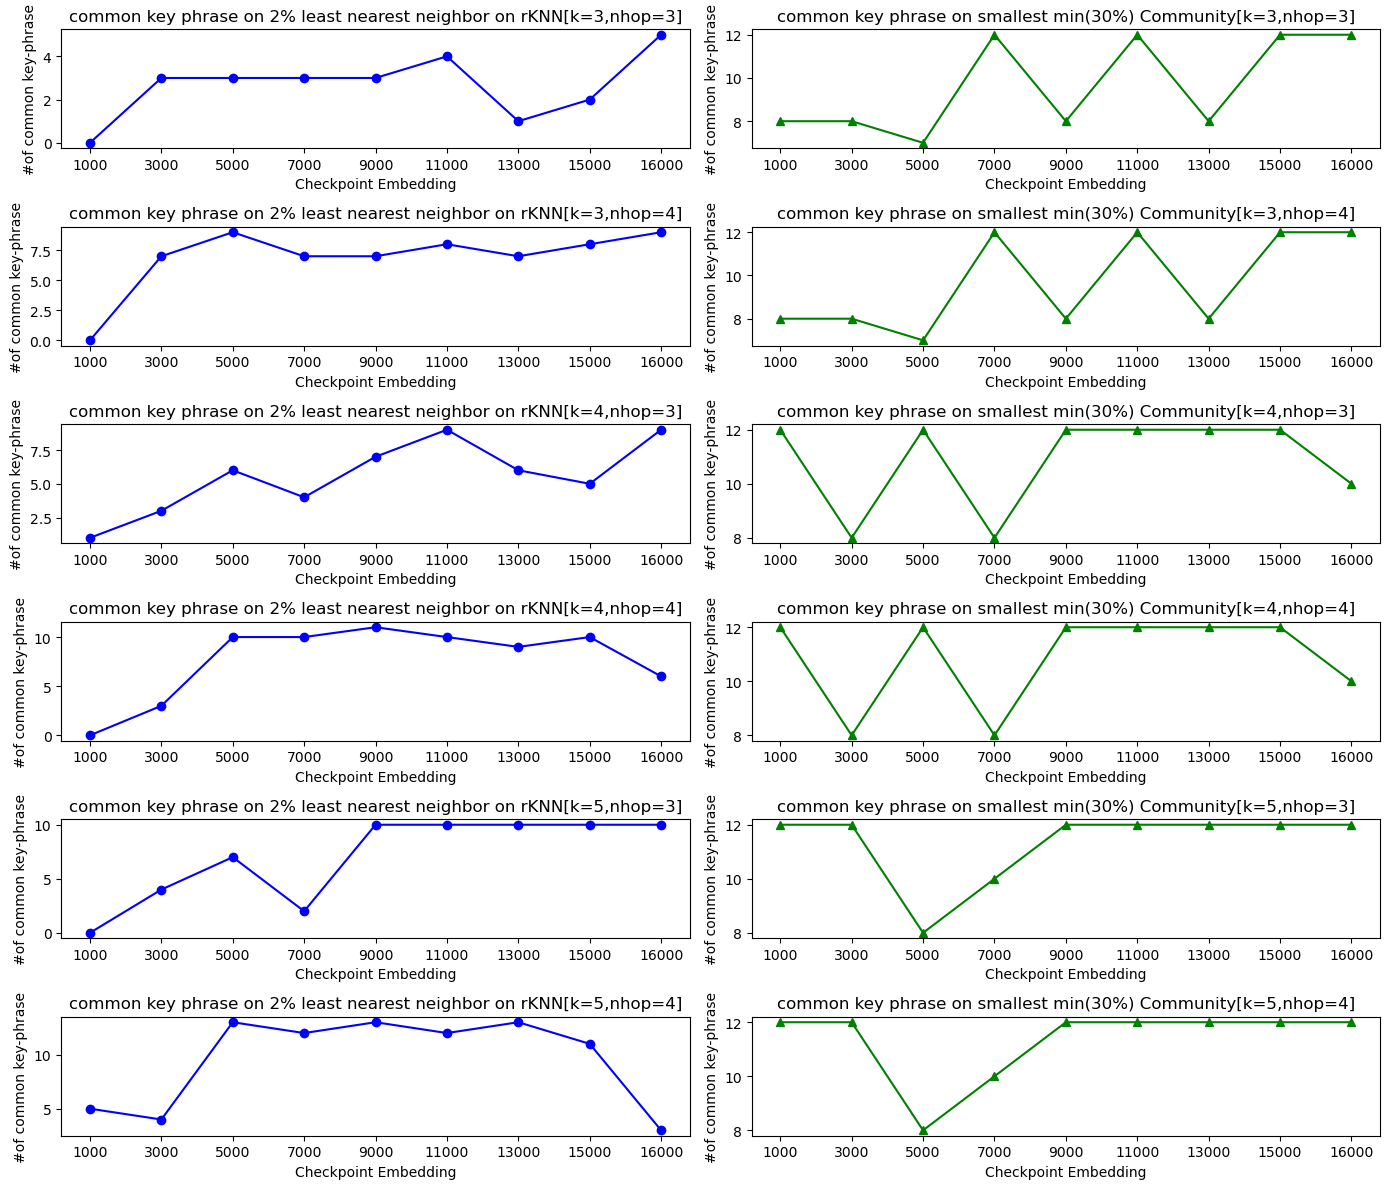

In [36]:
import matplotlib.pyplot as plt
nHops_values = [3,4]
K_values = [3,4,5]
plt_count = len(K_values)*len(nHops_values)
# Create a figure with three subplots (1 row, 3 columns)
fig, axs = plt.subplots(plt_count, 2, figsize=(14, 12))

x = ['1000', '3000', '5000', '7000', '9000', '11000', '13000', '15000', '16000']
plot_line =0
for k in K_values:
    for nhops in nHops_values:        
        temp = result_df[(result_df['k'] == k) & (result_df['nHops'] == nhops)]
        y_rknn, y_community_30 = [],[]
        for index,row in temp.iterrows():
            # print(row)
            y_rknn.append(row['least_neighbor_common_key_phrases_of_rknn'])
            y_community_30.append(row['community_min_common_key_phrases_30'])

        # Plot for the 1st subplot
        axs[plot_line][0].plot(x, y_rknn, marker='o', linestyle='-', color='b')
        axs[plot_line][0].set_title(f'common key phrase on 2% least nearest neighbor on rKNN[k={k},nhop={nhops}]')
        axs[plot_line][0].set_xlabel('Checkpoint Embedding')
        axs[plot_line][0].set_ylabel('#of common key-phrase')

        # Plot for the 2nd subplot 
        axs[plot_line][1].plot(x, y_community_30, marker='^', linestyle='-', color='g')
        axs[plot_line][1].set_title(f'common key phrase on smallest min(30%) Community[k={k},nhop={nhops}]')
        axs[plot_line][1].set_xlabel('Checkpoint Embedding')
        axs[plot_line][1].set_ylabel('#of common key-phrase')
                
        plot_line = plot_line +1

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

For k=3 and nHop=4 : 


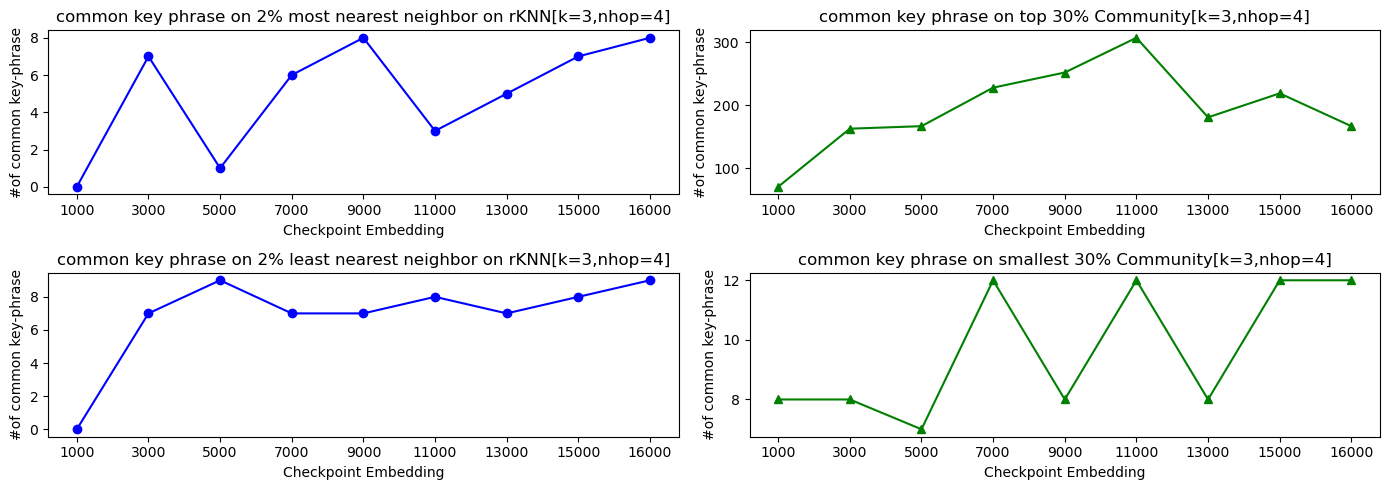

In [37]:
import matplotlib.pyplot as plt
#create plot for k=3, nhop=4
K_values = [3]
nHops_values = [4] 
# Create a figure with three subplots (2 row, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(14, 5))

x = ['1000', '3000', '5000', '7000', '9000', '11000', '13000', '15000', '16000']
for k in K_values:
    for nhops in nHops_values:
        print(f'For k={k} and nHop={nhops} : ')
        
        temp = result_df[(result_df['k'] == k) & (result_df['nHops'] == nhops)]
        y_rknn_most, y_community_top_30, y_rknn_least, y_community_smallest_30 = [],[],[],[]
        for index,row in temp.iterrows():
            y_rknn_most.append(row['most_neighbor_common_key_phrases_of_rknn'])
            y_community_top_30.append(row['community_max_common_key_phrases_30'])
            y_rknn_least.append(row['least_neighbor_common_key_phrases_of_rknn'])
            y_community_smallest_30.append(row['community_min_common_key_phrases_30'])

        # Plot for the first subplot
        axs[0][0].plot(x, y_rknn_most, marker='o', linestyle='-', color='b')
        axs[0][0].set_title(f'common key phrase on 2% most nearest neighbor on rKNN[k={k},nhop={nhops}]')
        axs[0][0].set_xlabel('Checkpoint Embedding')
        axs[0][0].set_ylabel('#of common key-phrase')

        # Plot for the third subplot 30
        axs[0][1].plot(x, y_community_top_30, marker='^', linestyle='-', color='g')
        axs[0][1].set_title(f'common key phrase on top 30% Community[k={k},nhop={nhops}]')
        axs[0][1].set_xlabel('Checkpoint Embedding')
        axs[0][1].set_ylabel('#of common key-phrase')
        
        
            
        # Plot for the first subplot
        axs[1][0].plot(x, y_rknn_least, marker='o', linestyle='-', color='b')
        axs[1][0].set_title(f'common key phrase on 2% least nearest neighbor on rKNN[k={k},nhop={nhops}]')
        axs[1][0].set_xlabel('Checkpoint Embedding')
        axs[1][0].set_ylabel('#of common key-phrase')

        # Plot for the third subplot 30
        axs[1][1].plot(x, y_community_smallest_30, marker='^', linestyle='-', color='g')
        axs[1][1].set_title(f'common key phrase on smallest 30% Community[k={k},nhop={nhops}]')
        axs[1][1].set_xlabel('Checkpoint Embedding')
        axs[1][1].set_ylabel('#of common key-phrase')
        
# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

# realtion with perplexity 

### relation between perplexity and  most_neighbor_common_key_phrases_of_rknn

In [38]:
def func1(value_2, value_1):
    res = ''
    diff = float(value_2) - float(value_1)
    if diff == 0.0:
        res = ''
    elif diff > 0.0 :
        res = '+'
    elif diff <0.0:
        res = '-'
    else:
        res = 'error'
    return res  

perplexity = ['735.09','164.02','270.42','223.63','96.67','252.14','619.23','105.01','220.84']
perplexity_val = []
for index, value in enumerate(perplexity[:-1]):
    perplexity_val.append(func1(perplexity[index+1],perplexity[index]))
# perplexity_val

x = ['1000', '3000', '5000', '7000', '9000', '11000', '13000', '15000', '16000']

K_values = [3,4,5]
nHops_values = [3,4]
observation_column = ['label', 'k_nhop_33','k_nhop_34','k_nhop_43','k_nhop_44','k_nhop_53','k_nhop_54','perplexity']
observation_data = []

for index, value in enumerate(x[:-1]):
    temp = []
    
    #label
    text = 'emb '+x[index]+' to '+x[index+1]
    # label_val.append(text)
    temp.append(text)
    
    # k,nhop
    k_nhop_count =0
    for k in K_values:
        for nHop in nHops_values:
            emb_text = 'embeddings_'+x[index]
            val_1 = result_df[(result_df['k'] == k) & (result_df['nHops'] == nHop) & (result_df['embedding'] == emb_text)]['most_neighbor_common_key_phrases_of_rknn']
            emb_text = 'embeddings_'+x[index+1]
            val_2 = result_df[(result_df['k'] == k) & (result_df['nHops'] == nHop) & (result_df['embedding'] == emb_text)]['most_neighbor_common_key_phrases_of_rknn']
            temp.append(func1(val_2.values[0],val_1.values[0]))

    temp.append(perplexity_val[index])
    observation_data.append(temp)
    
# observation_data
observation_df = pd.DataFrame(observation_data,columns=observation_column) 
print('For most_neighbor_common_key_phrases_of_rknn')
observation_df

For most_neighbor_common_key_phrases_of_rknn


label k_nhop_33 k_nhop_34 k_nhop_43 k_nhop_44 k_nhop_53  \
0    emb 1000 to 3000         +         +         +         +         +   
1    emb 3000 to 5000         -         -         +         -         -   
2    emb 5000 to 7000         +         +         -         +         +   
3    emb 7000 to 9000         -         +         +         -         +   
4   emb 9000 to 11000         -         -                   +         +   
5  emb 11000 to 13000         +         +         -         -         -   
6  emb 13000 to 15000         -         +         +         +         -   
7  emb 15000 to 16000         +         +         -         -         +   

  k_nhop_54 perplexity  
0         +          -  
1         -          +  
2         +          -  
3         -          -  
4         +          +  
5         -          +  
6                    -  
7         -          +

### relation between perplexity and  least_neighbor_common_key_phrases_of_rknn

In [39]:
observation_data = []

for index, value in enumerate(x[:-1]):
    temp = []
    
    #label
    text = 'emb '+x[index]+' to '+x[index+1]
    temp.append(text)
    
    # k,nhop
    k_nhop_count =0
    for k in K_values:
        for nHop in nHops_values:
            emb_text = 'embeddings_'+x[index]
            val_1 = result_df[(result_df['k'] == k) & (result_df['nHops'] == nHop) & (result_df['embedding'] == emb_text)]['least_neighbor_common_key_phrases_of_rknn']
            emb_text = 'embeddings_'+x[index+1]
            val_2 = result_df[(result_df['k'] == k) & (result_df['nHops'] == nHop) & (result_df['embedding'] == emb_text)]['least_neighbor_common_key_phrases_of_rknn']
            temp.append(func1(val_2.values[0],val_1.values[0]))

    temp.append(perplexity_val[index])
    observation_data.append(temp)

# observation_data
observation_df = pd.DataFrame(observation_data,columns=observation_column) 
print('For least_neighbor_common_key_phrases_of_rknn')
observation_df

For least_neighbor_common_key_phrases_of_rknn


label k_nhop_33 k_nhop_34 k_nhop_43 k_nhop_44 k_nhop_53  \
0    emb 1000 to 3000         +         +         +         +         +   
1    emb 3000 to 5000                   +         +         +         +   
2    emb 5000 to 7000                   -         -                   -   
3    emb 7000 to 9000                             +         +         +   
4   emb 9000 to 11000         +         +         +         -             
5  emb 11000 to 13000         -         -         -         -             
6  emb 13000 to 15000         +         +         -         +             
7  emb 15000 to 16000         +         +         +         -             

  k_nhop_54 perplexity  
0         -          -  
1         +          +  
2         -          -  
3         +          -  
4         -          +  
5         +          +  
6         -          -  
7         -          +

### relation between perplexity and  max_community_common_key_phrases

In [40]:
observation_column = ['label', 'k_3','k_4','k_5','perplexity']
observation_data = []

for index, value in enumerate(x[:-1]):
    temp = []
    
    #label
    text = 'emb '+x[index]+' to '+x[index+1]
    temp.append(text)
    
    # k,nhop
    k_nhop_count =0
    for k in K_values:
        emb_text = 'embeddings_'+x[index]
        val_1 = result_df[(result_df['k'] == k) & (result_df['nHops'] == 3) & (result_df['embedding'] == emb_text)]['community_max_common_key_phrases_30']
        emb_text = 'embeddings_'+x[index+1]
        val_2 = result_df[(result_df['k'] == k) & (result_df['nHops'] == 3) & (result_df['embedding'] == emb_text)]['community_max_common_key_phrases_30']
        temp.append(func1(val_2.values[0],val_1.values[0]))

    temp.append(perplexity_val[index])
    observation_data.append(temp)
    
# observation_data
observation_df = pd.DataFrame(observation_data,columns=observation_column) 
print('For community_max_common_key_phrases(30%)')
observation_df

For community_max_common_key_phrases(30%)


label k_3 k_4 k_5 perplexity
0    emb 1000 to 3000   +   +   +          -
1    emb 3000 to 5000   +   +   +          +
2    emb 5000 to 7000   +   -   +          -
3    emb 7000 to 9000   +   +   -          -
4   emb 9000 to 11000   +   -   -          +
5  emb 11000 to 13000   -   +   +          +
6  emb 13000 to 15000   +   -   -          -
7  emb 15000 to 16000   -   +   +          +

### relation between perplexity and  min_community_common_key_phrases

In [41]:
observation_column = ['label', 'k_3','k_4','k_5','perplexity']
observation_data = []

for index, value in enumerate(x[:-1]):
    temp = []
    
    #label
    text = 'emb '+x[index]+' to '+x[index+1]
    temp.append(text)
    
    # k,nhop
    k_nhop_count =0
    for k in K_values:
        emb_text = 'embeddings_'+x[index]
        val_1 = result_df[(result_df['k'] == k) & (result_df['nHops'] == 3) & (result_df['embedding'] == emb_text)]['community_min_common_key_phrases_30']
        emb_text = 'embeddings_'+x[index+1]
        val_2 = result_df[(result_df['k'] == k) & (result_df['nHops'] == 3) & (result_df['embedding'] == emb_text)]['community_min_common_key_phrases_30']
        temp.append(func1(val_2.values[0],val_1.values[0]))

    temp.append(perplexity_val[index])
    observation_data.append(temp)
    
# observation_data
observation_df = pd.DataFrame(observation_data,columns=observation_column) 
print('For community_min_common_key_phrases(30%)')
observation_df

For community_min_common_key_phrases(30%)


label k_3 k_4 k_5 perplexity
0    emb 1000 to 3000       -              -
1    emb 3000 to 5000   -   +   -          +
2    emb 5000 to 7000   +   -   +          -
3    emb 7000 to 9000   -   +   +          -
4   emb 9000 to 11000   +                  +
5  emb 11000 to 13000   -                  +
6  emb 13000 to 15000   +                  -
7  emb 15000 to 16000       -              +